# Sistemas dinámicos, complejidad y caos con Python

*Esta notebook fue creada originalmente como un blog post por [Raúl E. López Briega](https://relopezbriega.com.ar/) en [Matemáticas, Analisis de datos y Python](https://relopezbriega.github.io). El contenido esta bajo la licencia BSD.*

<img alt="Sistemas dinámicos, complejidad y caos" title="Sistemas dinámicos, complejidad y caos" src="https://relopezbriega.github.io/images/ComplexPy.jpg" width="80%" height="80%">

> "El lenguaje sirve no sólo para expresar el pensamiento, sino para hacer posibles pensamientos que no podrían existir sin él."

**[Bertrand Russell](https://es.wikipedia.org/wiki/Bertrand_Russell)**

## Introducción

El

In [1]:
# <!-- collapse=True -->
# Importando las librerías que vamos a utilizar
import pandas as pd
import numpy as np
import random
from scipy.stats import rv_discrete as rv
from scipy import integrate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation
import math
import numba

# graficos incrustados
%matplotlib inline

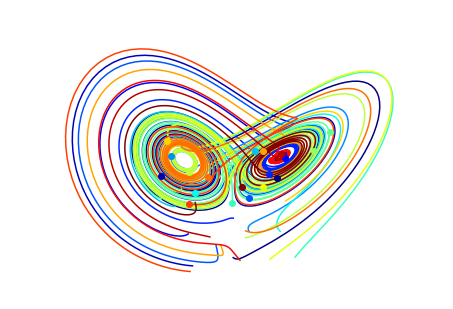

In [3]:
# <!-- collapse=True -->
N_trajectories = 20

def lorentz_deriv(x_y_z, t0, sigma=10., beta=8./3, rho=28.0):
    """Compute the time-derivative of a Lorentz system."""
    (x, y, z) = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

# Choose random starting points, uniformly distributed from -15 to 15
np.random.seed(1)
x0 = -15 + 30 * np.random.random((N_trajectories, 3))

# Solve for the trajectories
t = np.linspace(0, 4, 1000)
x_t = np.asarray([integrate.odeint(lorentz_deriv, x0i, t)
                  for x0i in x0])

# Set up figure & 3D axis for animation
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1], projection='3d')
ax.axis('off')

# choose a different color for each trajectory
colors = plt.cm.jet(np.linspace(0, 1, N_trajectories))

# set up lines and points
lines = sum([ax.plot([], [], [], '-', c=c)
             for c in colors], [])
pts = sum([ax.plot([], [], [], 'o', c=c)
           for c in colors], [])

# prepare the axes limits
ax.set_xlim((-25, 25))
ax.set_ylim((-35, 35))
ax.set_zlim((5, 55))

# set point-of-view: specified by (altitude degrees, azimuth degrees)
ax.view_init(30, 0)

# initialization function: plot the background of each frame
def init():
    for line, pt in zip(lines, pts):
        line.set_data([], [])
        line.set_3d_properties([])

        pt.set_data([], [])
        pt.set_3d_properties([])
    return lines + pts

# animation function.  This will be called sequentially with the frame number
def animate(i):
    # we'll step two time-steps per frame.  This leads to nice results.
    i = (2 * i) % x_t.shape[1]

    for line, pt, xi in zip(lines, pts, x_t):
        x, y, z = xi[:i].T
        line.set_data(x, y)
        line.set_3d_properties(z)

        pt.set_data(x[-1:], y[-1:])
        pt.set_3d_properties(z[-1:])

    ax.view_init(30, 0.3 * i)
    fig.canvas.draw()
    return lines + pts

# instantiate the animator.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=500, interval=30, blit=True)

# Save as mp4. This requires mplayer or ffmpeg to be installed
anim.save('lorentz_attractor.mp4', fps=15, extra_args=['-vcodec', 'libx264'])

plt.show()

In [10]:
%%HTML
<video width="320" height="240" controls>
  <source src="https://relopezbriega.github.io/images/lorentz_attractor.mp4" type="video/mp4">
</video>

In [4]:
# <!-- collapse=True -->
A = np.array([[[0.0,0.0],[0.00,0.16]],
          [[0.85,0.04],[-0.04,0.85]],
          [[0.2,-0.26],[0.23,0.22]],
          [[-0.15,0.28],[0.26,0.24]]])

b = np.array([[0.00,0.00],
              [0.00,1.60],
              [0.00,1.60],
              [0.00,0.44]])

#next_transform = rv(name='Fern',values=((0,1,2,3),(0.01,0.85,0.0,0.14)))
next_transform = rv(name='Fern',values=((0,1,2,3),(0.01,0.85,0.07,0.07)))

def simplify_axes(ax):
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlim(-2.3,2.8)
    ax.set_ylim(-0.1,10.1)


def next_point(last_point):
    transform = next_transform.rvs()
    return np.dot(A[transform],last_point) + b[transform]

def fern():
    current = np.array([0.0, 0.0])

    fig = plt.figure()
    ax = fig.add_subplot(111)
    simplify_axes(ax)
    
    # Don't plot the first few iterations.
    for x in range(15):
        current = next_point(current)

    ax.plot(current[0], current[1], 'go', markersize=1)
    xs, ys = [], []
    line_fern, = ax.plot(xs, ys, 'go', markersize=1)

    for x in range(60000):
        current = next_point(current)
        xs.append(current[0])
        ys.append(current[1])
        line_fern.set_data(xs, ys)
    
    plt.show()

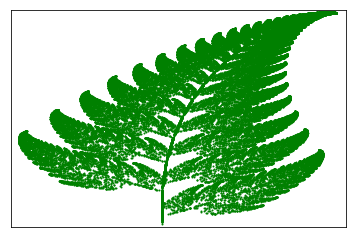

In [5]:
fern()

In [6]:
# <!-- collapse=True -->
corner = np.array([[0.0, 0.0], [1.0, 0.0], [0.5, 0.5]])

def simplify_axes(ax):
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlim(corner[:,0].min()-0.1,corner[:,0].max()+0.1)
    ax.set_ylim(corner[:,1].min()-0.1,corner[:,1].max()+0.1)

def next_point(last_point):
    target_point = random.choice(corner)
    return (last_point + target_point) / 2

def sierpinski():
    current = np.array([0.0, 0.0])

    fig = plt.figure()
    ax = fig.add_subplot(111)
    simplify_axes(ax)
    
    # Don't plot the first few iterations.
    for x in range(15):
        current = next_point(current)

    ax.plot(current[0], current[1], 'ko', markersize=1)
    xs, ys = [], []
    line_sierp, = ax.plot(xs, ys, 'ko', markersize=1)

    for x in range(50000):
        current = next_point(current)
        xs.append(current[0])
        ys.append(current[1])
        line_sierp.set_data(xs, ys)
    
    plt.show()

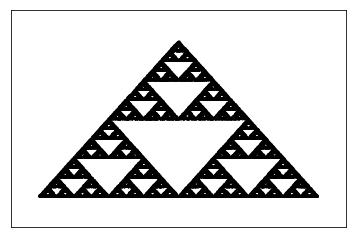

In [7]:
sierpinski()

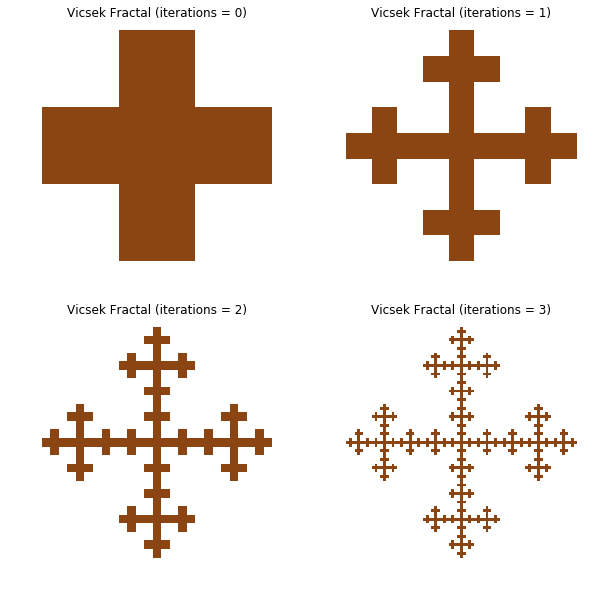

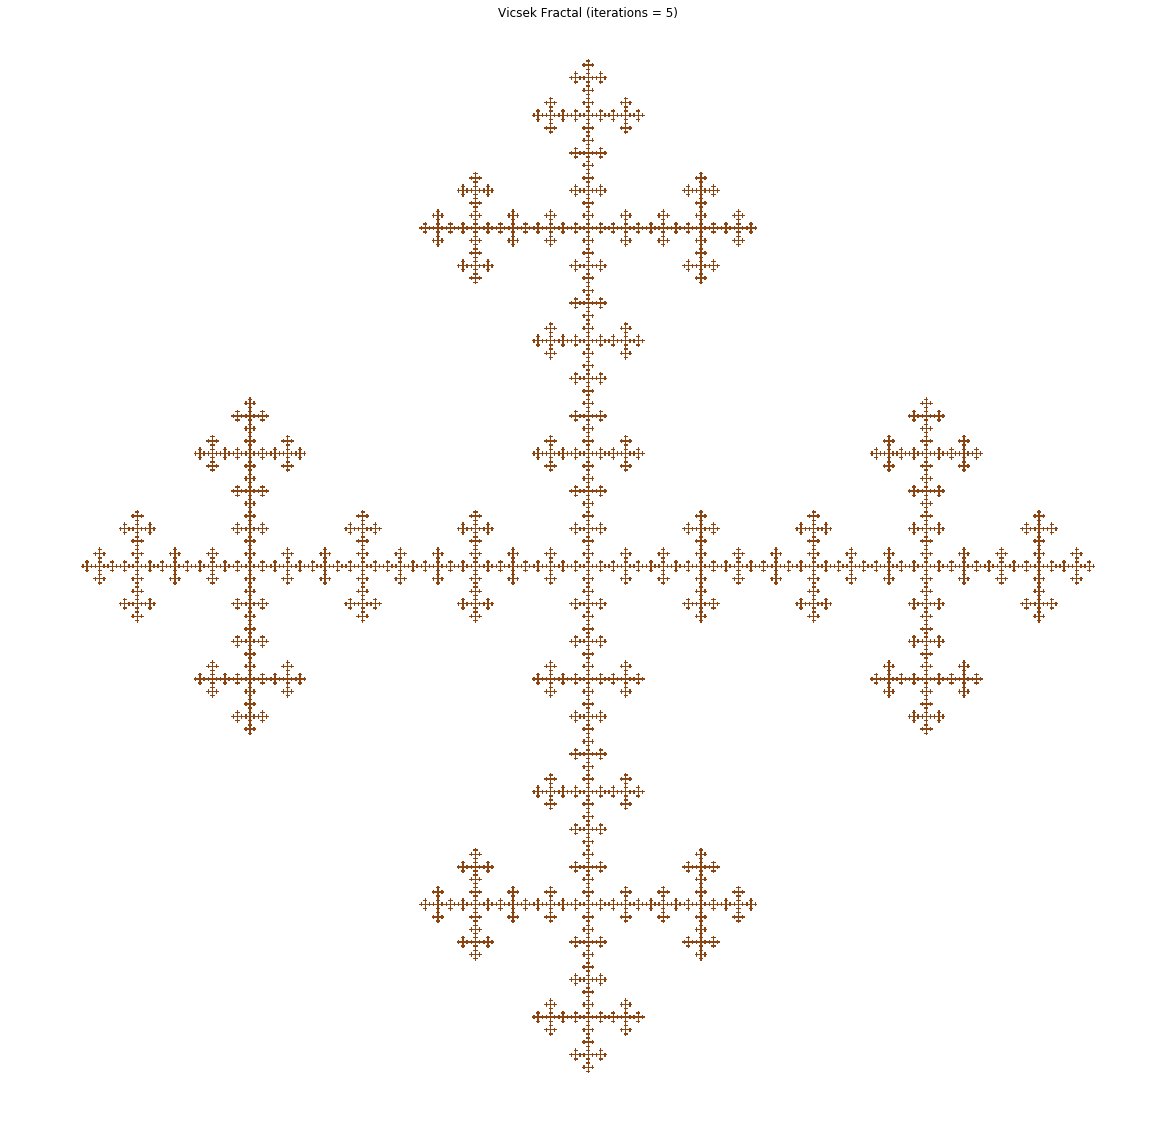

In [8]:
# <!-- collapse=True -->
def vicsek(a, b, c, d, iterations, offset=np.array([0,0])):

    ab = (a + b)/3.
    ba = 2*(a + b)/3.
    bc = (2*b + c)/3.
    cb = (b + 2*c)/3.
    dc = (c + 2*d)/3.
    cd = (2*c + d)/3.
    ad = (d + a)/3.
    da = 2*(d + a)/3.

    abd = 2*a/3. + (b + d)/3.
    bac = a + (2*b + d)/3.
    cbd = 4*a/3. + 2*(b + d)/3.
    dac = a + (b + 2*d)/3.


    if iterations == 0:
        plt.fill([ab[0]+offset[0],ba[0]+offset[0],bac[0]+offset[0],bc[0]+offset[0],
        cb[0]+offset[0],cbd[0]+offset[0],cd[0]+offset[0],dc[0]+offset[0],dac[0]+offset[0],
        da[0]+offset[0],ad[0]+offset[0],abd[0]+offset[0]],
        [ab[1]+offset[1],ba[1]+offset[1],bac[1]+offset[1],bc[1]+offset[1],
        cb[1]+offset[1],cbd[1]+offset[1],cd[1]+offset[1],dc[1]+offset[1],
        dac[1]+offset[1],da[1]+offset[1],ad[1]+offset[1],abd[1]+offset[1]],
        'saddlebrown')
        plt.hold(True)
    else:
        abd_m =np.array([0,0])
        bac_m = bac - abd
        cbd_m = cbd - abd
        dac_m = dac - abd
        offset1= offset +abd
        vicsek(abd_m, bac_m, cbd_m, dac_m, iterations - 1,offset1)

        ab_m =np.array([0,0])
        ba_m = ba - ab
        bac_m = bac - ab
        abd_m = abd - ab
        offset2= offset +ab
        vicsek(ab_m, ba_m, bac_m, abd_m, iterations - 1,offset2)

   
        bac_m =np.array([0,0])
        bc_m = bc - bac
        cb_m = cb - bac
        cbd_m = cbd - bac
        offset4= offset +bac
        vicsek(bac_m, bc_m, cb_m, cbd_m, iterations - 1,offset4)

     
        dac_m = np.array([0, 0])
        cbd_m = cbd - dac
        cd_m = cd - dac
        dc_m = dc - dac
        offset6= offset +dac
        vicsek(dac_m, cbd_m, cd_m, dc_m, iterations - 1,offset6)

        ad_m = np.array([0, 0])
        abd_m = abd - ad
        dac_m = dac - ad
        da_m = da - ad
        offset8= offset +ad
        vicsek(ad_m, abd_m, dac_m, da_m, iterations - 1,offset8)

a = np.array([0, 0])
b = np.array([3, 0])
c = np.array([3, 3])
d = np.array([0, 3])

fig = plt.figure(figsize=(10,10))

iterations = 0

plt.subplot(2,2,1).set_title("Vicsek Fractal (iterations = 0)")

vicsek(a, b, c, d, iterations)

plt.axis('equal')
plt.axis('off')


iterations = 1

plt.subplot(2,2,2).set_title("Vicsek Fractal (iterations = 1)")

vicsek(a, b, c, d, iterations)

plt.axis('equal')
plt.axis('off')


iterations = 2

plt.subplot(2,2,3).set_title("Vicsek Fractal (iterations = 2)")

vicsek(a, b, c, d, iterations)

plt.axis('equal')
plt.axis('off')


iterations = 3

plt.subplot(2,2,4).set_title("Vicsek Fractal (iterations = 3)")

vicsek(a, b, c, d, iterations)

plt.axis('equal')
plt.axis('off')

iterations = 5

plt.figure(figsize=(20,20))
vicsek(a, b, c, d, iterations)
#plt.hold(False)
plt.title("Vicsek Fractal (iterations = 5)")
plt.axis('equal')
plt.axis('off')

plt.show()

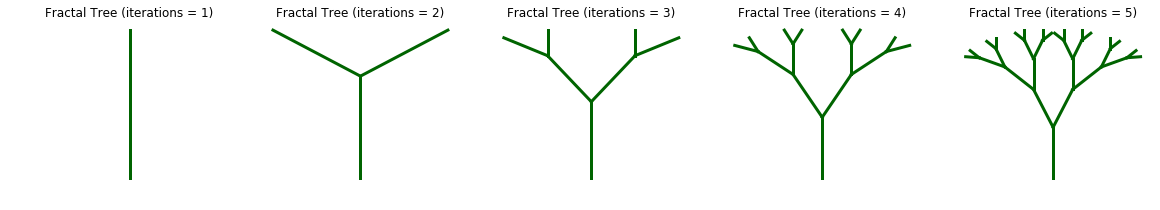

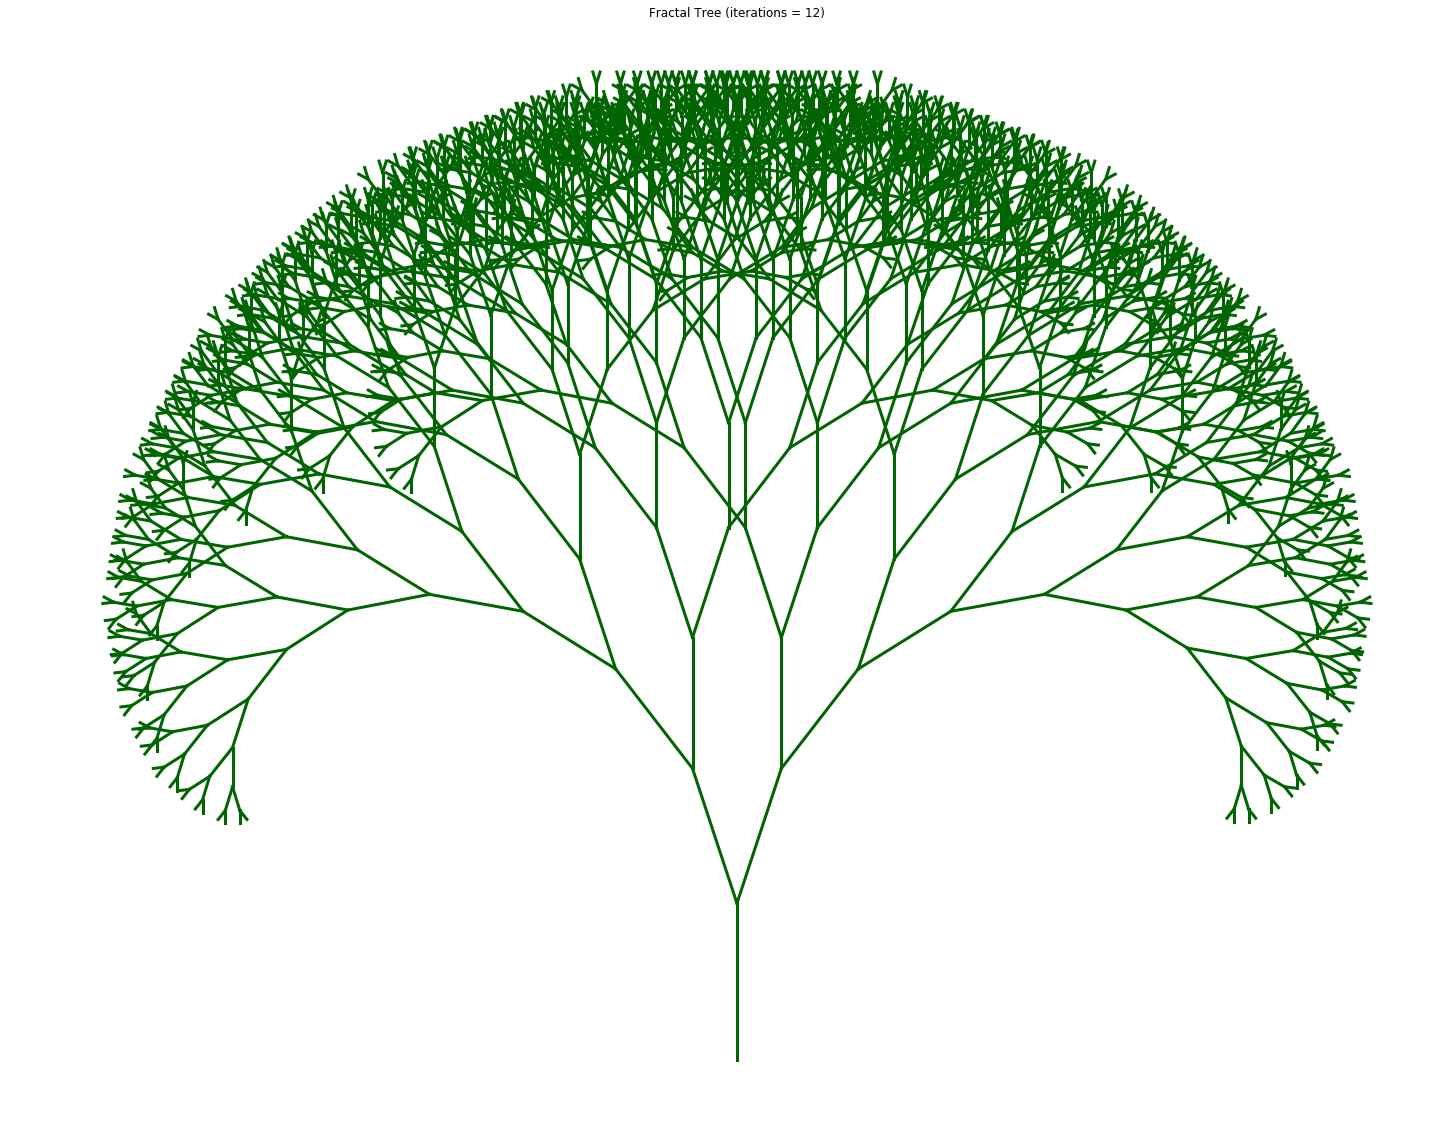

In [10]:
# <!-- collapse=True -->
def drawTree(x1, y1, angle, depth):

    if depth:
        x2 = x1 + int(math.cos(math.radians(angle)) * depth * 10.0)
        y2 = y1 + int(math.sin(math.radians(angle)) * depth * 10.0)
        plt.plot([x1,x2],[y1,y2],'-',color='darkgreen',lw=3)
        drawTree(x2, y2, angle - 20, depth - 1)
        drawTree(x2, y2, angle + 20, depth - 1)

plt.figure(figsize=(20,3))

plt.subplot(1,5,1)
depth=1
drawTree(300, 550, 90, depth)
s="Fractal Tree (iterations = %i)" %depth
plt.title(s)
plt.axis('off')

plt.subplot(1,5,2)
depth=2
drawTree(300, 550, 90, depth)
s="Fractal Tree (iterations = %i)" %depth
plt.title(s)
plt.axis('off')

plt.subplot(1,5,3)
depth=3
drawTree(300, 550, 90, depth)
s="Fractal Tree (iterations = %i)" %depth
plt.title(s)
plt.axis('off')

plt.subplot(1,5,4)
depth=4
drawTree(300, 550, 90, depth)
s="Fractal Tree (iterations = %i)" %depth
plt.title(s)
plt.axis('off')

plt.subplot(1,5,5)
depth=5
drawTree(300, 550, 90, depth)
s="Fractal Tree (iterations = %i)" %depth
plt.title(s)
plt.axis('off')

plt.figure(figsize=(25,20))
depth=12
drawTree(300, 550, 90, depth)
#drawTree(300, 550, 45, depth)
#drawTree(300, 550, 135, depth)
s="Fractal Tree (iterations = %i)" %depth
plt.title(s)
plt.axis('off')

plt.show()

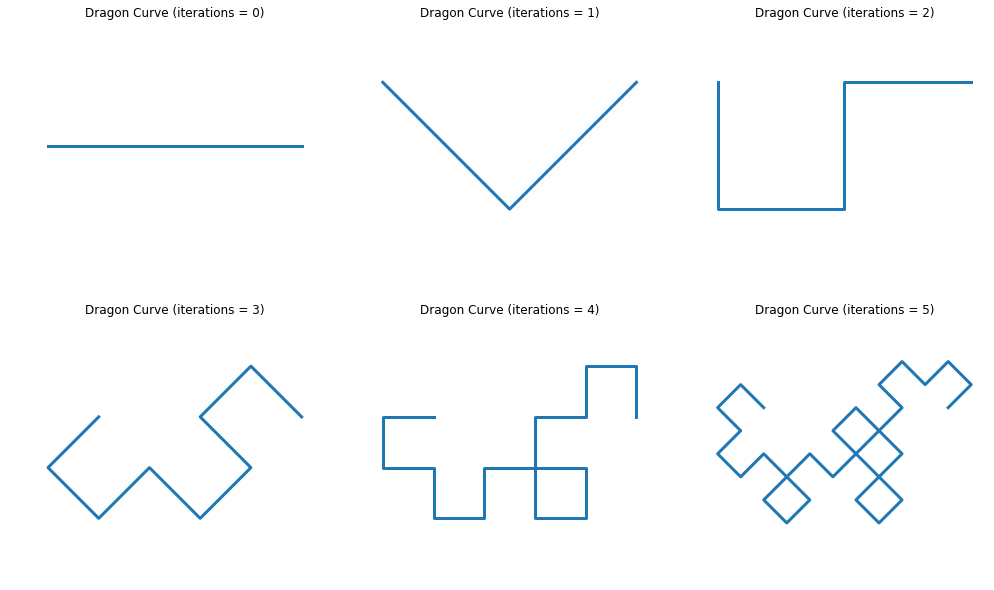

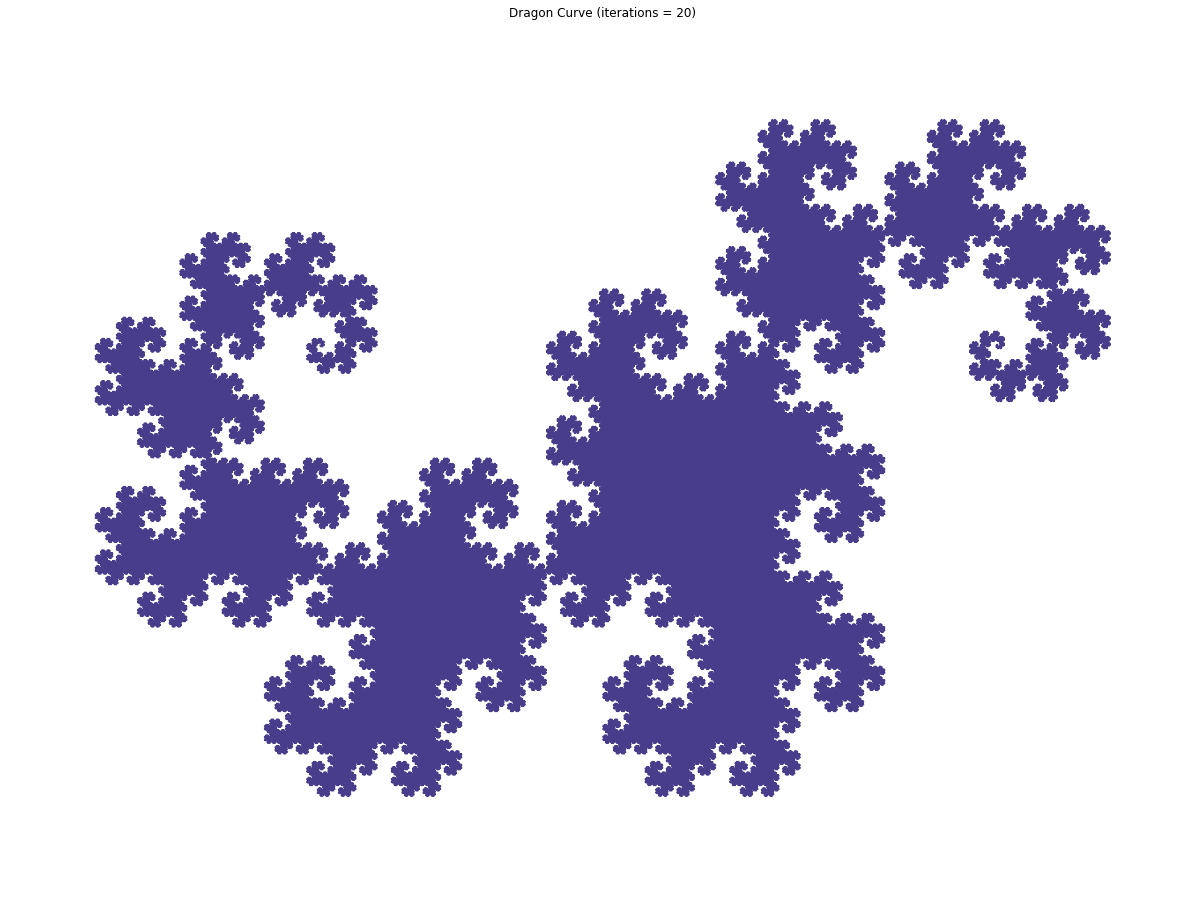

In [11]:
# <!-- collapse=True -->
def L_system(level, initial_state, trgt, rplcmnt, trgt2, rplcmnt2):
    state = initial_state
   
    for counter in range(level):
        state2 = ''
        for character in state:
            if character == trgt:
                state2 += rplcmnt
            elif character == trgt2:
                state2 += rplcmnt2
            else:
                state2 += character
        state = state2
    return state

def L(angle,coords,jump):
    return angle + math.radians(45)
def R(angle,coords,jump):
    return angle - math.radians(45)
def l(angle,coords,jump):
    return angle + math.radians(90)
def r(angle,coords,jump):
    return angle - math.radians(90)

def F(angle, coords, jump):
    coords.append(
        (coords[-1][0] + jump * math.cos(angle),
         coords[-1][1] + jump * math.sin(angle)))
    return angle

def G(angle,coords,jump):
    coords.append(
        (coords[-1][0] + cosin[angle],
            coords[-1][1] +sines[angle]))
    return angle

decode = dict(L=L, R=R, F=F, G=G,l=l,r=r)

def dragon(steps, length=200, startPos=(0,0)):
    starting= 'R'*steps+'FX'
    pathcodes = L_system(steps,  starting, 'X', 'XlYFl', 'Y', 'rFXrY')
    jump = float(length) / (2 ** steps)
    coords = [startPos]
    angle = 0
    for move in pathcodes:
        if move == 'F' or move =='r' or move== 'l' or move == 'R':
            angle= decode[move](angle,coords,jump)
    return coords



totalwidth=100
iterations = 0

fig = plt.figure(figsize=(17,10))
points = dragon(iterations,totalwidth,(-totalwidth/2,0))

plt.subplot(2,3,1).set_title("Dragon Curve (iterations = 0)")
    
plt.plot([p[0] for p in points], [p[1] for p in points], '-',lw=3)#,lw=5)
plt.axis('equal')
plt.axis('off')

iterations = 1

plt.subplot(2,3,2).set_title("Dragon Curve (iterations = 1)")

points = dragon(iterations,totalwidth,(-totalwidth/2,0))
plt.plot([p[0] for p in points], [p[1] for p in points], '-',lw=3)#,lw=5)
plt.axis('equal')
plt.axis('off')

iterations = 2

plt.subplot(2,3,3).set_title("Dragon Curve (iterations = 2)")

points = dragon(iterations,totalwidth,(-totalwidth/2,0))
plt.plot([p[0] for p in points], [p[1] for p in points], '-',lw=3)#,lw=5)
plt.axis('equal')
plt.axis('off')

iterations = 3

plt.subplot(2,3,4).set_title("Dragon Curve (iterations = 3)")

points = dragon(iterations,totalwidth,(-totalwidth/2,0))
plt.plot([p[0] for p in points], [p[1] for p in points], '-',lw=3)#,lw=5)
plt.axis('equal')
plt.axis('off')

iterations = 4

plt.subplot(2,3,5).set_title("Dragon Curve (iterations = 4)")

points = dragon(iterations,totalwidth,(-totalwidth/2,0))
plt.plot([p[0] for p in points], [p[1] for p in points], '-',lw=3)#,lw=5)
plt.axis('equal')
plt.axis('off')

iterations = 5

plt.subplot(2,3,6).set_title("Dragon Curve (iterations = 5)")

points = dragon(iterations,totalwidth,(-totalwidth/2,0))
plt.plot([p[0] for p in points], [p[1] for p in points], '-',lw=3)#,lw=5)
plt.axis('equal')
plt.axis('off')

iterations = 20

plt.figure(figsize=(20,16))

points = dragon(iterations,totalwidth,(-totalwidth/2,0))
plt.plot([p[0] for p in points], [p[1] for p in points], '-',color='darkslateblue')#,lw=5)
plt.axis('equal')
plt.axis('off')

plt.title("Dragon Curve (iterations = 20)")

plt.show()

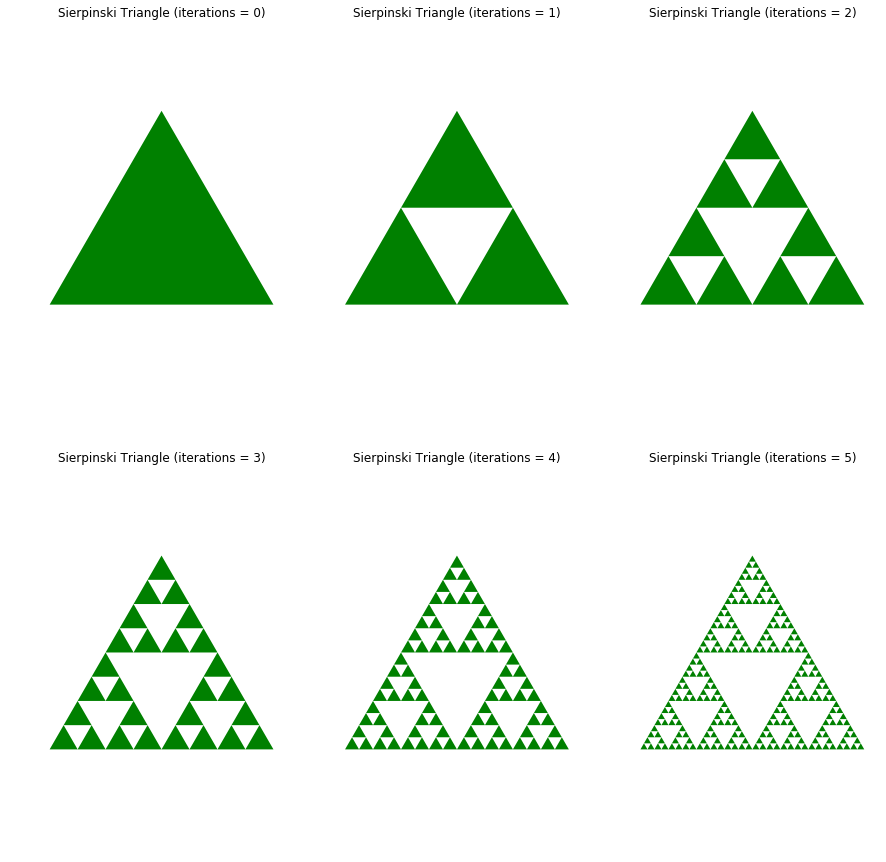

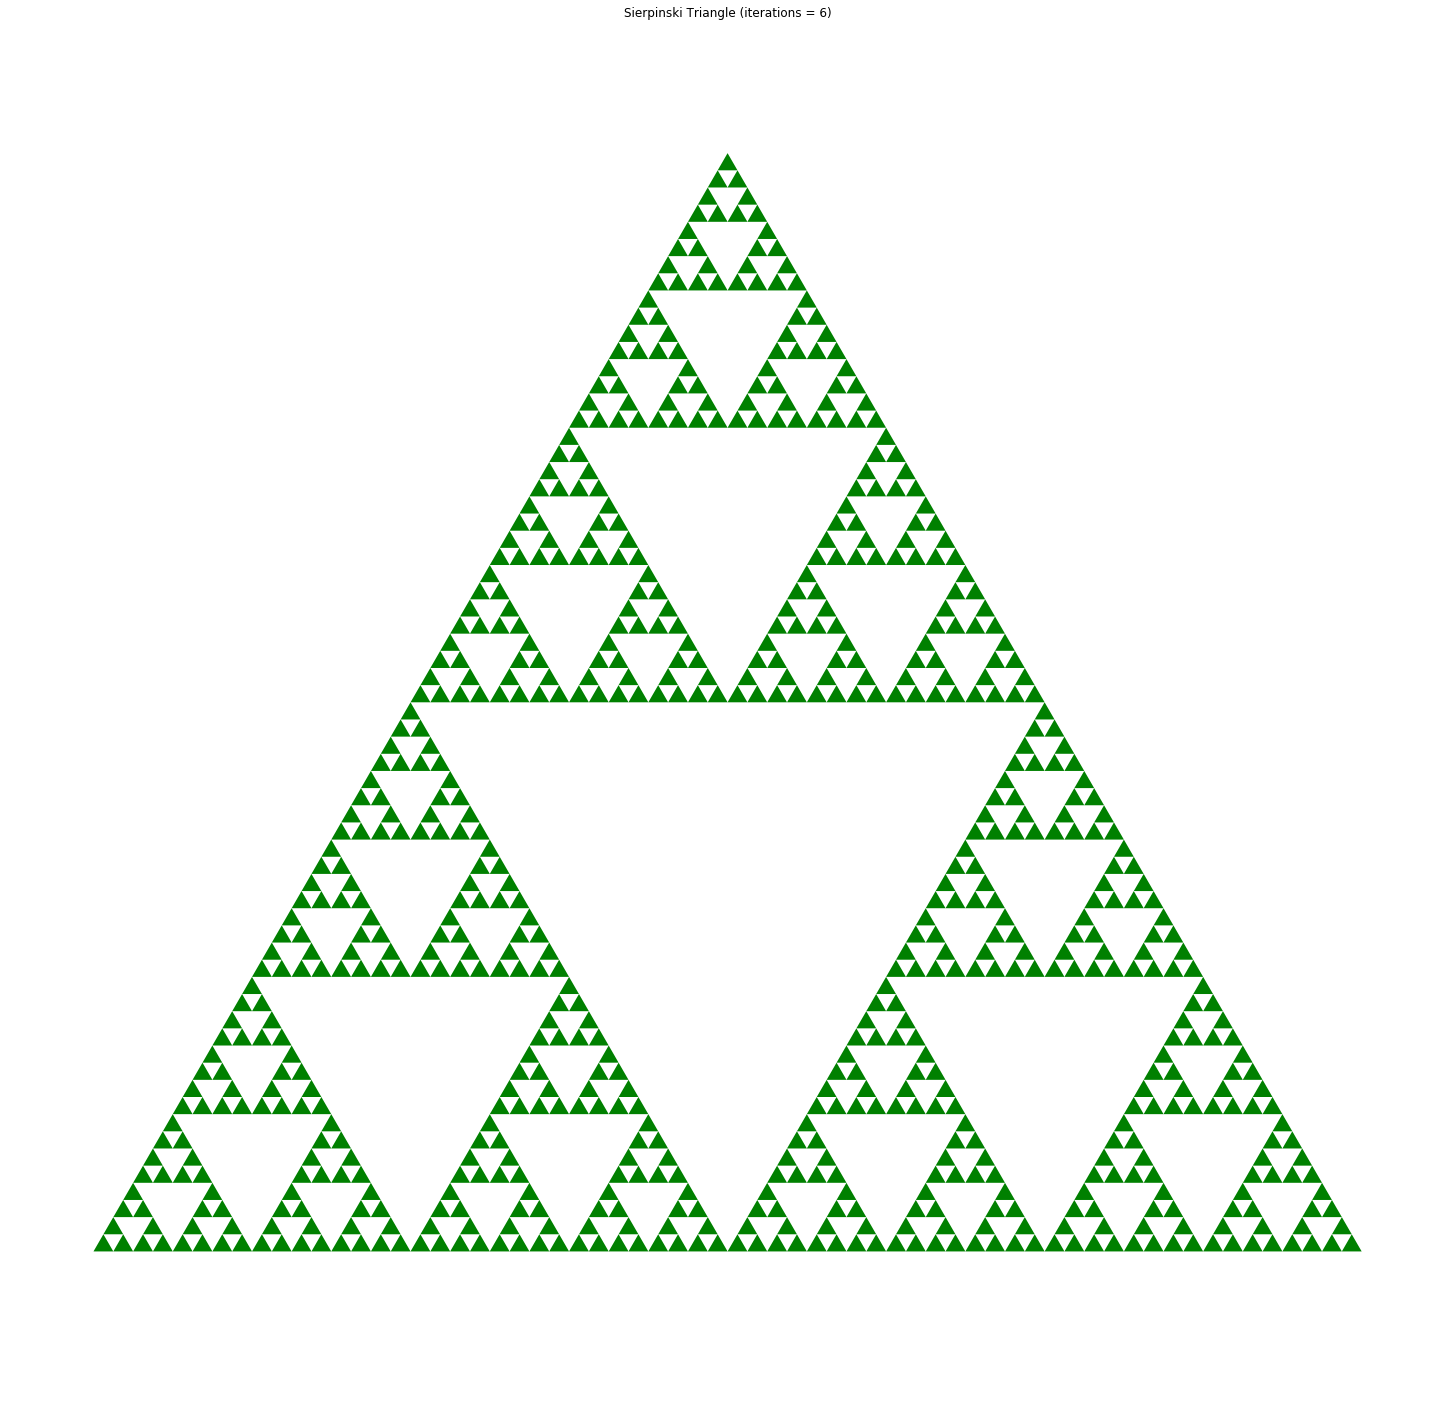

In [12]:
# <!-- collapse=True -->
def SierpinskiTriangle(a, b, c, iterations):
    '''
    Recursively generated Sierpinski Triangle. 
    '''
    if iterations == 0:
        # Fill the triangle with vertices a, b, c. 
        plt.fill([a[0], b[0], c[0]], [a[1], b[1], c[1]], 'g') 
        plt.hold(True)
    else:
        # Recursive calls for the three subtriangles. 
        SierpinskiTriangle(a, (a + b) / 2., (a + c) / 2., iterations - 1) 
        SierpinskiTriangle(b, (b + a) / 2., (b + c) / 2., iterations - 1) 
        SierpinskiTriangle(c, (c + a) / 2., (c + b) / 2., iterations - 1)
        
a = np.array([0, 0])
b = np.array([1, 0])
c = np.array([0.5, np.sqrt(3)/2.])

iterations = 0

fig = plt.figure(figsize=(15,15))
plt.subplot(2,3,1).set_title("Sierpinski Triangle (iterations = 0)")

SierpinskiTriangle(a, b, c, iterations)

plt.axis('equal')
plt.axis('off')

iterations = 1

plt.subplot(2,3,2).set_title("Sierpinski Triangle (iterations = 1)")

SierpinskiTriangle(a, b, c, iterations)

plt.axis('equal')
plt.axis('off')

iterations = 2

plt.subplot(2,3,3).set_title("Sierpinski Triangle (iterations = 2)")

SierpinskiTriangle(a, b, c, iterations)

plt.axis('equal')
plt.axis('off')

iterations = 3

plt.subplot(2,3,4).set_title("Sierpinski Triangle (iterations = 3)")

SierpinskiTriangle(a, b, c, iterations)

plt.axis('equal')
plt.axis('off')

iterations = 4

plt.subplot(2,3,5).set_title("Sierpinski Triangle (iterations = 4)")

SierpinskiTriangle(a, b, c, iterations)

plt.axis('equal')
plt.axis('off')

iterations = 5

plt.subplot(2,3,6).set_title("Sierpinski Triangle (iterations = 5)")

SierpinskiTriangle(a, b, c, iterations)

plt.axis('equal')
plt.axis('off')

iterations = 6

plt.figure(figsize=(25,25))

SierpinskiTriangle(a, b, c, iterations)

plt.title("Sierpinski Triangle (iterations = 6)")
plt.axis('equal')
plt.axis('off')
plt.show()

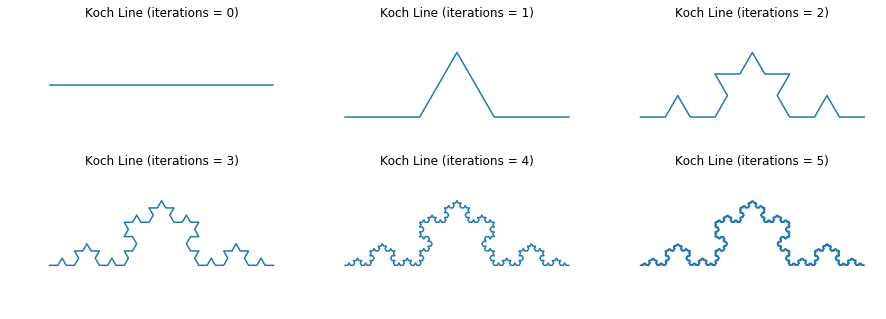

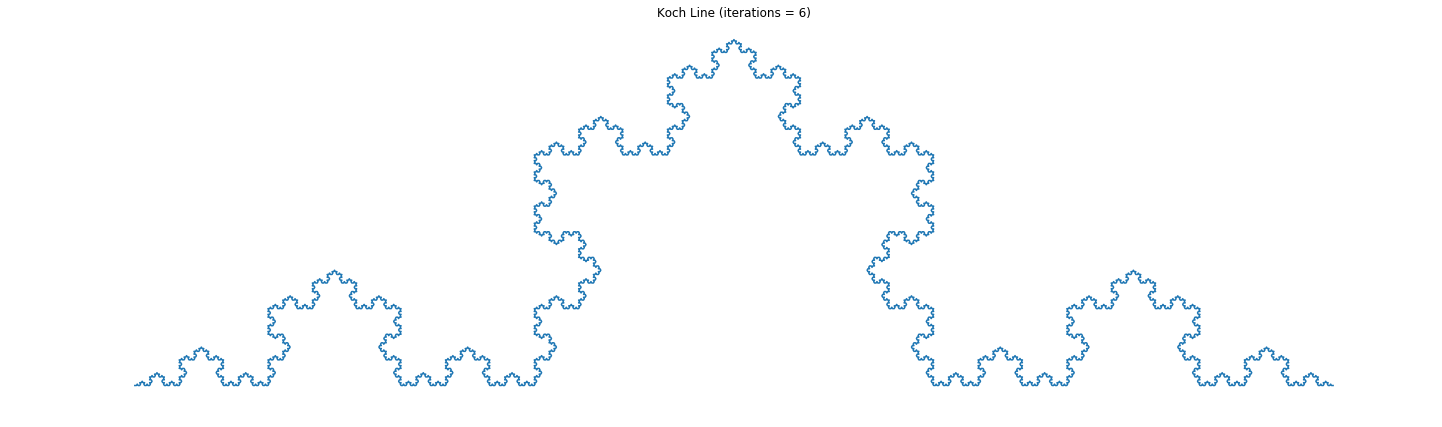

In [13]:
# <!-- collapse=True -->
def koch(a,b,iterations):

    a1=a[0]
    a2=a[1]
    
    b1=b[0]
    b2=b[1]
    
    theta = np.arctan((b2-a2)/(b1-a1))
    length = np.sqrt((a1-b1)**2+(a2-b2)**2)
    
    c1 = (2*a1+b1)/3.
    c2 = (2*a2+b2)/3.
    c = [c1,c2]
    
    d1 = (a1+2*b1)/3.
    d2 = (a2+2*b2)/3.
    d = [d1,d2]
    
    if c1 >= a1:
        m1 = c1 + (length/3.)*math.cos(theta+math.pi/3.)
        m2 = c2 + (length/3.)*math.sin(theta+math.pi/3.)
    else:
        m1 = c1 + (length/3.)*math.cos(theta-2*math.pi/3.)
        m2 = c2 + (length/3.)*math.sin(theta-2*math.pi/3.)
    m = [m1,m2]
    
    c = np.array(c)
    d = np.array(d)
    m = np.array(m)
    
    points = []
    
    if iterations == 0:
        points.extend([a,b])
    elif iterations == 1:
        points.extend([a, c, m, d, b])
    else:
        points.extend(koch(a,c,iterations-1))
        points.extend(koch(c,m,iterations-1))
        points.extend(koch(m,d,iterations-1))
        points.extend(koch(d,b,iterations-1))  
                        
    return points



fig = plt.figure(figsize=(15,5))

plt.subplot(2,3,1).set_title("Koch Line (iterations = 0)")
points = koch(a=np.array([0, 0]),b=np.array([1,0]),iterations=0)
ptsx=[]
ptsy=[]
for i in range(len(points)):
    ptsx.append(points[i][0])
    ptsy.append(points[i][1])
plt.plot(ptsx, ptsy, '-')
plt.axis('equal')
plt.axis('off')

plt.subplot(2,3,2).set_title("Koch Line (iterations = 1)")
points = koch(a=np.array([0, 0]),b=np.array([1,0]),iterations=1)
ptsx=[]
ptsy=[]
for i in range(len(points)):
    ptsx.append(points[i][0])
    ptsy.append(points[i][1])
plt.plot(ptsx, ptsy, '-')
plt.axis('equal')
plt.axis('off')

plt.subplot(2,3,3).set_title("Koch Line (iterations = 2)")
points = koch(a=np.array([0, 0]),b=np.array([1,0]),iterations=2)
ptsx=[]
ptsy=[]
for i in range(len(points)):
    ptsx.append(points[i][0])
    ptsy.append(points[i][1])
plt.plot(ptsx, ptsy, '-')
plt.axis('equal')
plt.axis('off')

plt.subplot(2,3,4).set_title("Koch Line (iterations = 3)")
points = koch(a=np.array([0, 0]),b=np.array([1,0]),iterations=3)
ptsx=[]
ptsy=[]
for i in range(len(points)):
    ptsx.append(points[i][0])
    ptsy.append(points[i][1])
plt.plot(ptsx, ptsy, '-')
plt.axis('equal')
plt.axis('off')


plt.subplot(2,3,5).set_title("Koch Line (iterations = 4)")
points = koch(a=np.array([0, 0]),b=np.array([1,0]),iterations=4)
ptsx=[]
ptsy=[]
for i in range(len(points)):
    ptsx.append(points[i][0])
    ptsy.append(points[i][1])
plt.plot(ptsx, ptsy, '-')
plt.axis('equal')
plt.axis('off')

plt.subplot(2,3,6).set_title("Koch Line (iterations = 5)")
points = koch(a=np.array([0, 0]),b=np.array([1,0]),iterations=5)
ptsx=[]
ptsy=[]
for i in range(len(points)):
    ptsx.append(points[i][0])
    ptsy.append(points[i][1])
plt.plot(ptsx, ptsy, '-')
plt.axis('equal')
plt.axis('off')




plt.figure(figsize=(25,7))

plt.title("Koch Line (iterations = 6)")
points = koch(a=np.array([0, 0]),b=np.array([1,0]),iterations=6)
ptsx=[]
ptsy=[]
for i in range(len(points)):
    ptsx.append(points[i][0])
    ptsy.append(points[i][1])
plt.plot(ptsx, ptsy, '-')
plt.axis('equal')
plt.axis('off')
plt.show()

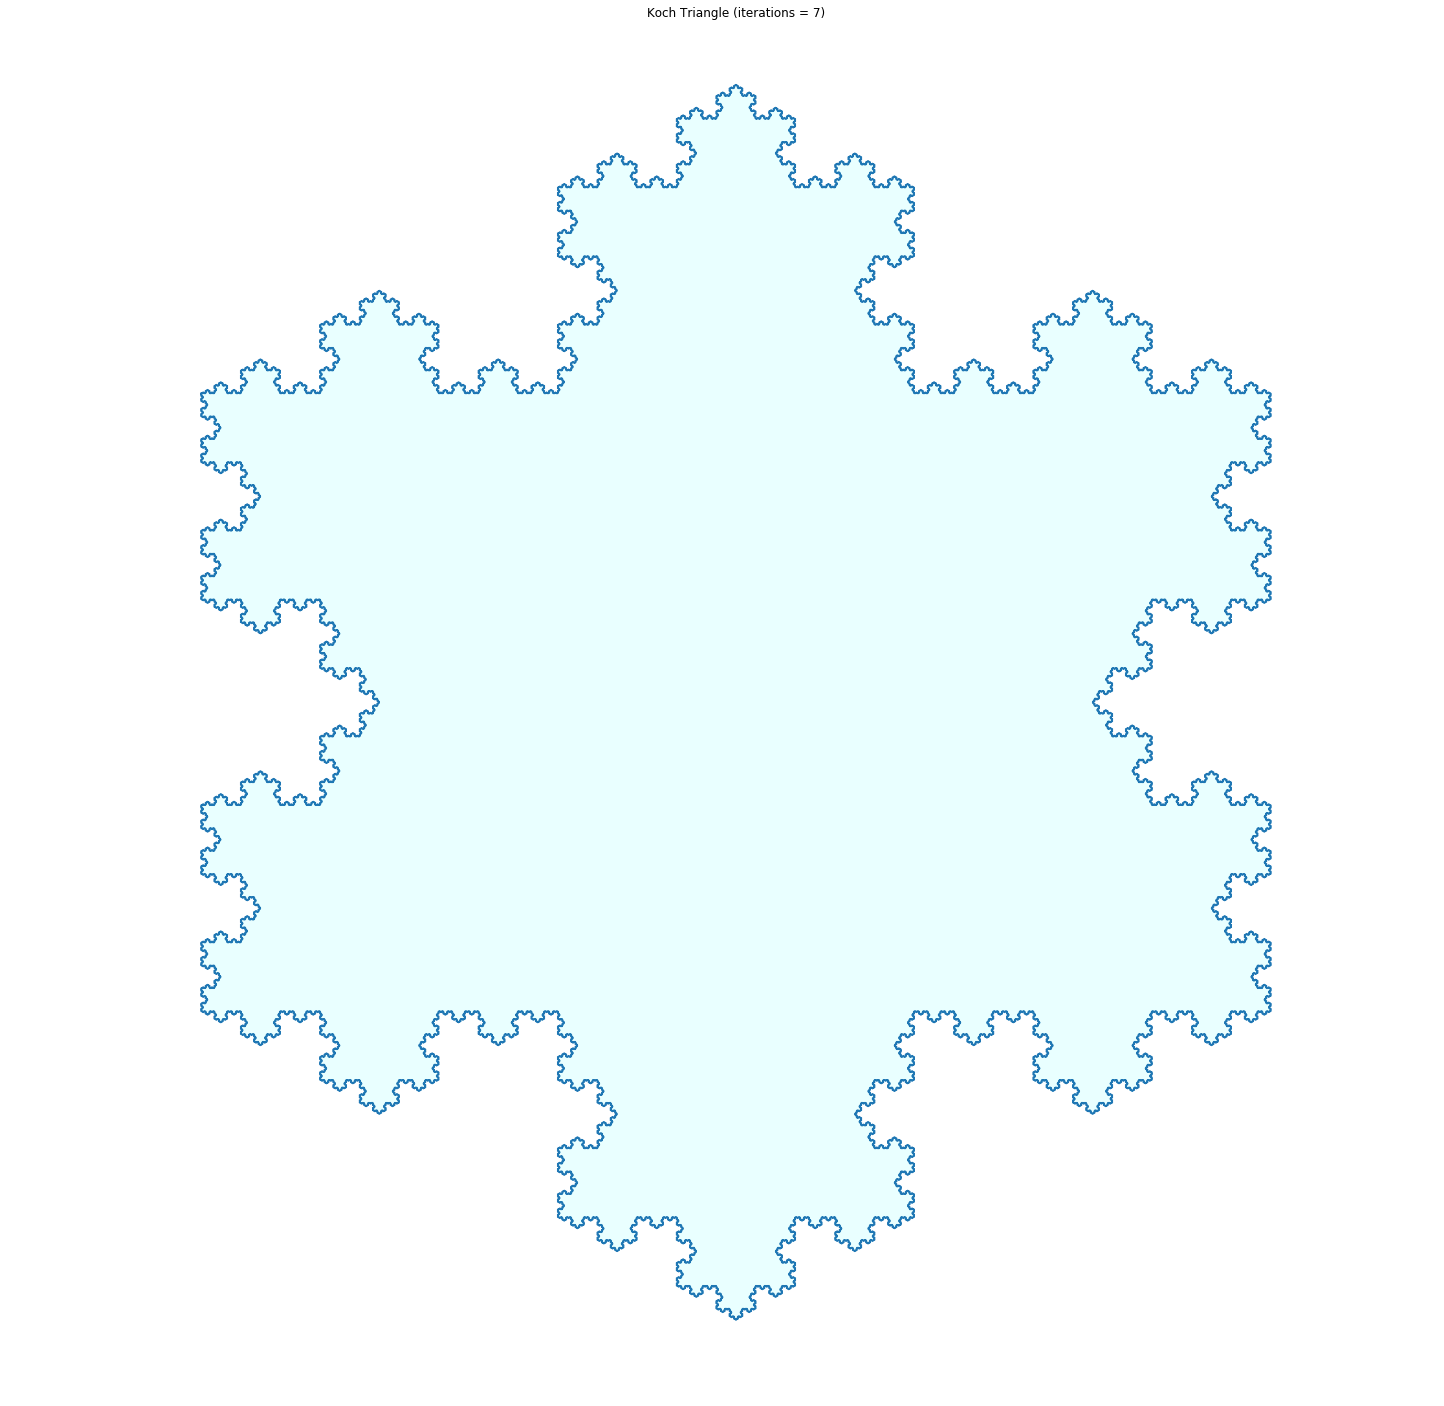

In [14]:
# <!-- collapse=True -->
h = np.sqrt(3)/2.
a = np.array([0, 0])
b = np.array([1, 0])
c = np.array([0.5, h])

iterations = 7

points1 = koch(a=np.array([0, 0]),b=np.array([1,0]),iterations=iterations)
points2 = koch(a=np.array([1, 0]),b=np.array([0.5,-h]),iterations=iterations)
points3 = koch(a=np.array([0.5, -h]),b=np.array([0,0]),iterations=iterations)

points = []
for i in range(len(points1)):
    points.append(np.array(points1[i]))
for i in range(len(points2)):
    points.append(np.array(points2[i]))
for i in range(len(points3)):
    points.append(np.array(points3[i]))

ptsx=[]
ptsy=[]
for i in range(len(points)):
    ptsx.append(points[i][0])
    ptsy.append(points[i][1])

plt.figure(figsize=(25,25))

plt.title("Koch Triangle (iterations = 7)")
plt.plot(ptsx, ptsy, '-')
plt.fill(ptsx, ptsy, color='lightcyan',alpha=0.7)
plt.axis('equal')
plt.axis('off')
plt.show()

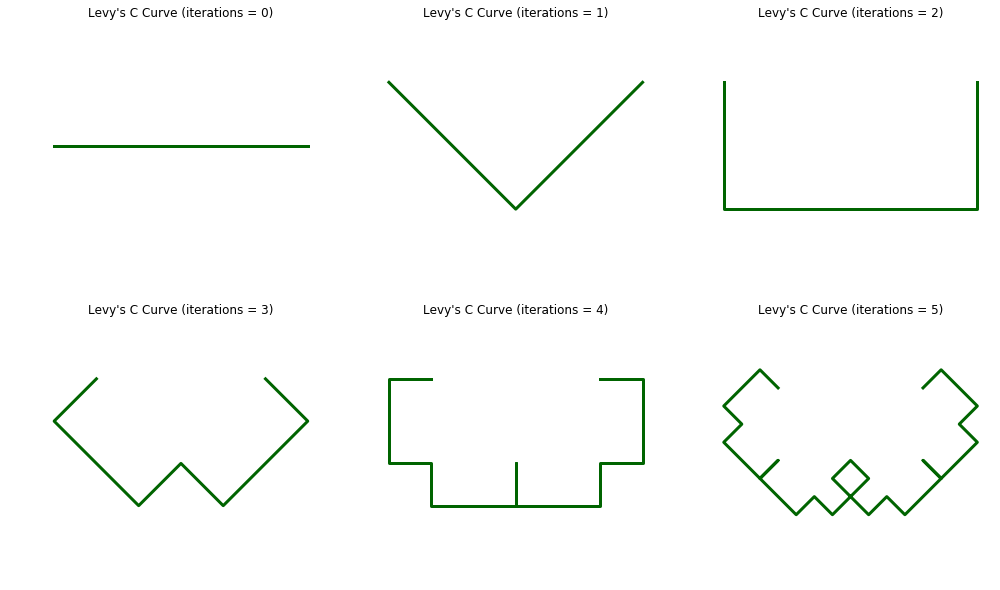

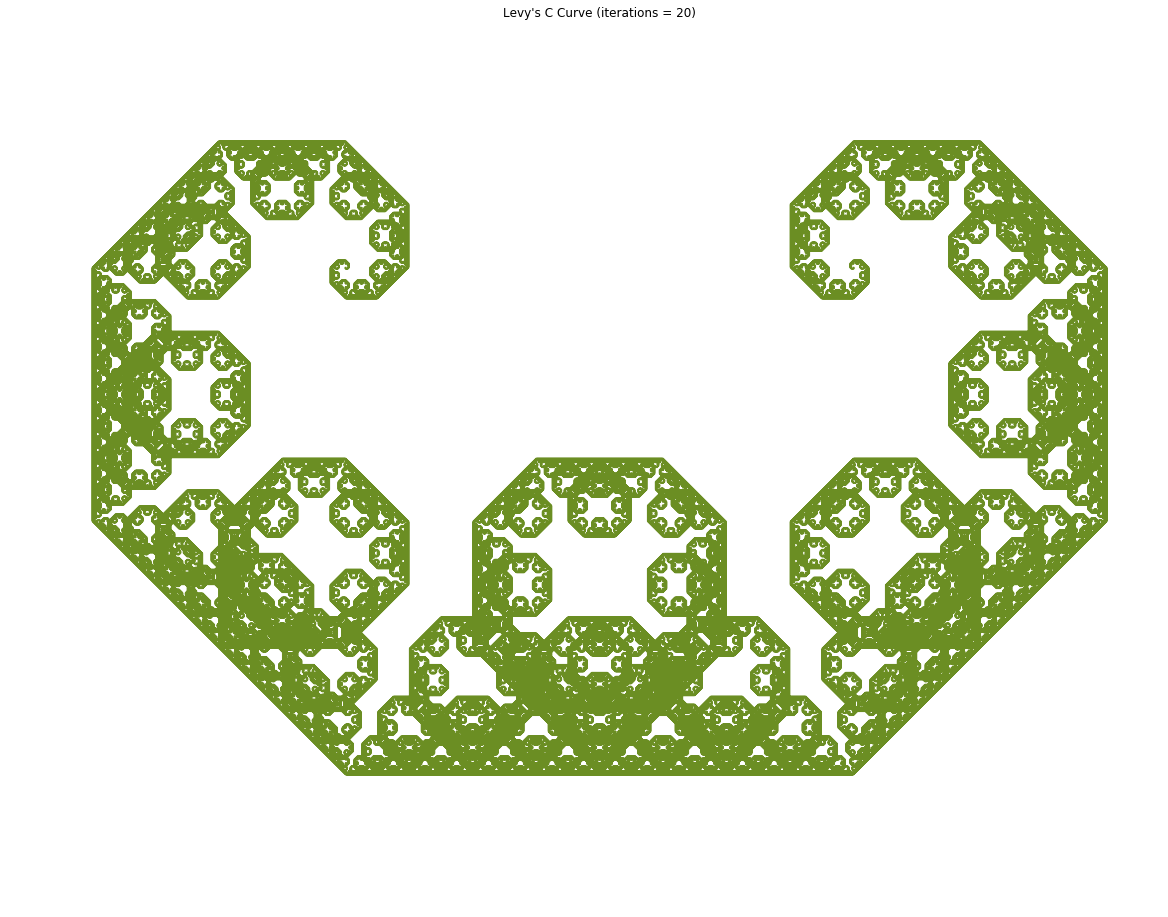

In [15]:
# <!-- collapse=True -->
def L_system(level, initial_state, trgt, rplcmnt, trgt2, rplcmnt2):
    state = initial_state
   
    for counter in range(level):
        state2 = ''
        for character in state:
            if character == trgt:
                state2 += rplcmnt
            elif character == trgt2:
                state2 += rplcmnt2
            else:
                state2 += character
        state = state2
    return state

def L(angle,coords,jump):
    return angle + math.radians(45)
def R(angle,coords,jump):
    return angle - math.radians(45)
def l(angle,coords,jump):
    return angle + math.radians(45)
def r(angle,coords,jump):
    return angle - math.radians(45)

def F(angle, coords, jump):
    coords.append(
        (coords[-1][0] + jump * math.cos(angle),
         coords[-1][1] + jump * math.sin(angle)))
    return angle

def G(angle,coords,jump):
    coords.append(
        (coords[-1][0] + cosin[angle],
            coords[-1][1] +sines[angle]))
    return angle

decode = dict(L=L, R=R, F=F, G=G,l=l,r=r)

def levyc(steps, length=200, startPos=(0,0)):
    starting= 'R'*steps+'FX'
    pathcodes = L_system(steps,  'F', 'F', 'rFllFr', '', '')
    jump = float(length) / (math.sqrt(2) ** steps)
    coords = [startPos]
    angle = 0
    for move in pathcodes:
        if move == 'F' or move =='r' or move== 'l' or move == 'R':
            angle= decode[move](angle,coords,jump)
    return coords



totalwidth=100
iterations = 0

fig = plt.figure(figsize=(17,10))
points = levyc(iterations,totalwidth,(-totalwidth/2,0))

plt.subplot(2,3,1).set_title("Levy's C Curve (iterations = 0)")
    
plt.plot([p[0] for p in points], [p[1] for p in points], '-',lw=3,color='darkgreen')
plt.axis('equal')
plt.axis('off')

iterations = 1

plt.subplot(2,3,2).set_title("Levy's C Curve (iterations = 1)")

points = levyc(iterations,totalwidth,(-totalwidth/2,0))
plt.plot([p[0] for p in points], [p[1] for p in points], '-',lw=3,color='darkgreen')
plt.axis('equal')
plt.axis('off')

iterations = 2

plt.subplot(2,3,3).set_title("Levy's C Curve (iterations = 2)")

points = levyc(iterations,totalwidth,(-totalwidth/2,0))
plt.plot([p[0] for p in points], [p[1] for p in points], '-',lw=3,color='darkgreen')
plt.axis('equal')
plt.axis('off')

iterations = 3

plt.subplot(2,3,4).set_title("Levy's C Curve (iterations = 3)")

points = levyc(iterations,totalwidth,(-totalwidth/2,0))
plt.plot([p[0] for p in points], [p[1] for p in points], '-',lw=3,color='darkgreen')
plt.axis('equal')
plt.axis('off')

iterations = 4

plt.subplot(2,3,5).set_title("Levy's C Curve (iterations = 4)")

points = levyc(iterations,totalwidth,(-totalwidth/2,0))
plt.plot([p[0] for p in points], [p[1] for p in points], '-',lw=3,color='darkgreen')
plt.axis('equal')
plt.axis('off')

iterations = 5

plt.subplot(2,3,6).set_title("Levy's C Curve (iterations = 5)")

points = levyc(iterations,totalwidth,(-totalwidth/2,0))
plt.plot([p[0] for p in points], [p[1] for p in points], '-',lw=3,color='darkgreen')
plt.axis('equal')
plt.axis('off')

iterations = 20

plt.figure(figsize=(20,16))

points = levyc(iterations,totalwidth,(-totalwidth/2,0))
plt.plot([p[0] for p in points], [p[1] for p in points], '-',color='olivedrab')
plt.axis('equal')
plt.axis('off')

plt.title("Levy's C Curve (iterations = 20)")

plt.show()

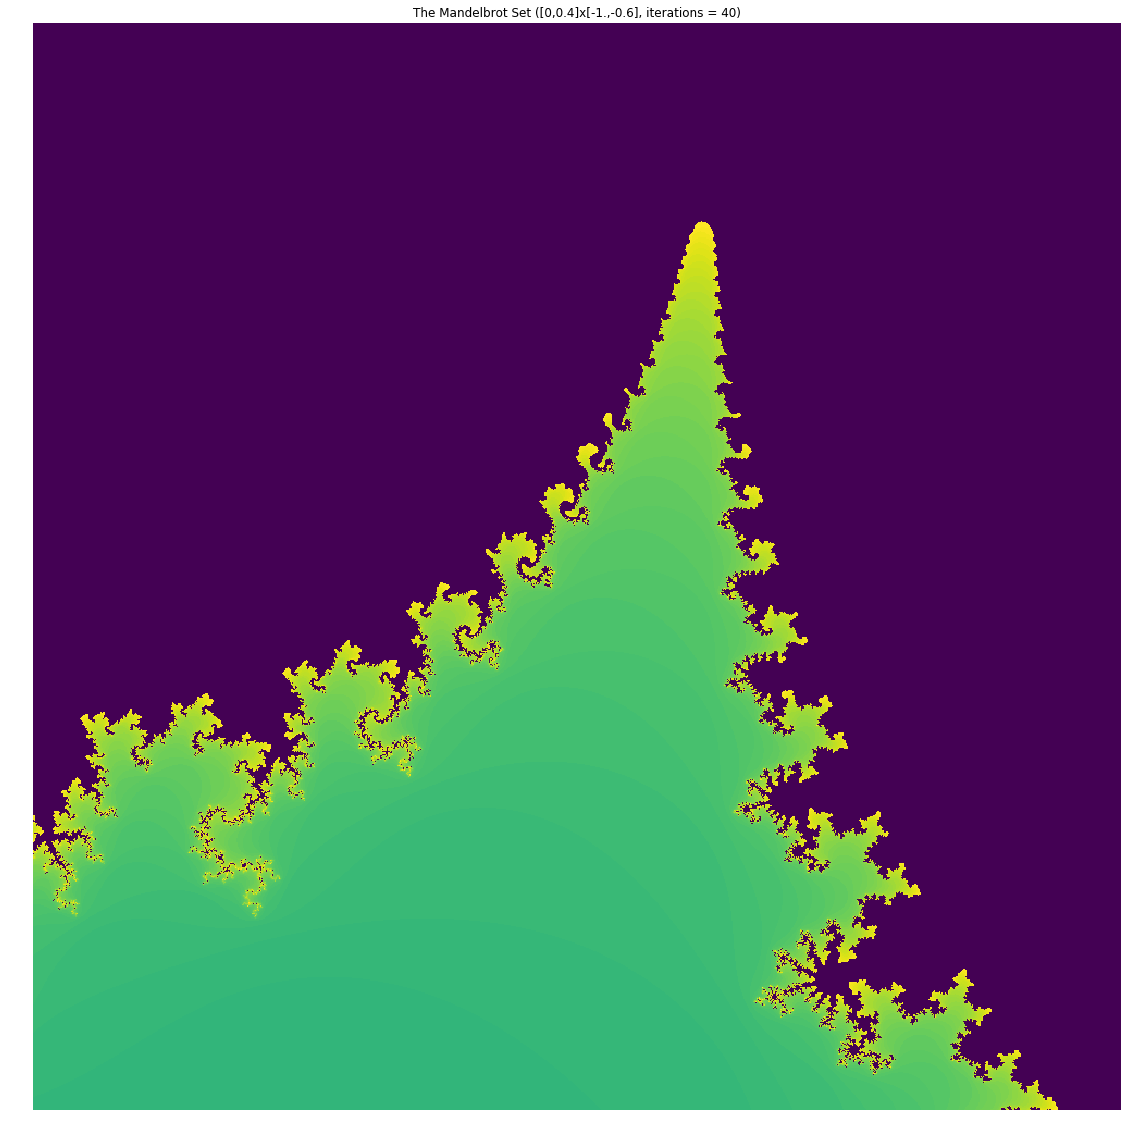

In [21]:
# <!-- collapse=True -->
def mandelbrot( h,w, maxit=40): #20
        '''
        Returns an image of the Mandelbrot fractal of size (h,w).
        '''
        y,x = ogrid[ -1.4:1.4:h*1j, -2:0.8:w*1j ]
        #y,x = ogrid[ -0.25:0.25:h*1j, -1.8:-1.3:w*1j ]
        #y,x = ogrid[ -0.05:0.05:h*1j, -1.5:-1.4:w*1j ]
        c = x+y*1j
        z = c
        divtime = maxit + np.zeros(z.shape, dtype=int)
        for i in xrange(maxit):
                z  = z**2 + c
                diverge = z*conj(z) > 2**2            # who is diverging
                div_now = diverge & (divtime==maxit)  # who is diverging now
                divtime[div_now] = i  +100                # note when
                z[diverge] = 2                        # avoid diverging too much

        return divtime
def mandelbrot2( h,w,a=-2.,b=.8,c=-1.4,d=1.4, maxit=40): #20
        '''
        Returns an image of the Mandelbrot fractal of size (h,w).
        '''
        y,x = np.ogrid[ c:d:h*1j, a:b:w*1j ]
        # y,x = ogrid[ -0.25:0.25:h*1j, -1.8:-1.3:w*1j ]
        #y,x = ogrid[ -0.05:0.05:h*1j, -1.5:-1.4:w*1j ]
        c = x+y*1j
        z = c
        divtime = maxit + np.zeros(z.shape, dtype=int)
        for i in range(maxit):
                z  = z**2 + c
                diverge = z*np.conj(z) > 2**2            # who is diverging
                div_now = diverge & (divtime==maxit)  # who is diverging now
                divtime[div_now] = i  +100                # note when
                z[diverge] = 2                        # avoid diverging too much

        return divtime

#fig = plt.figure(figsize=(15,15))
plt.figure(figsize=(20,20))

#fig = plt.subplot(4,1,1)#,figsize=(20,20))

plt.imshow(mandelbrot2(1000,1000)) 
#s = "The Mandelbrot Set ([-2.0,0.8]x[-1.4,1.4], iterations = 40)"
#s = "The Mandelbrot Set ([-1.8,-1.3]x[-0.25,0.25], iterations = 40)"
s = "The Mandelbrot Set ([-1.5,-1.4]x[-0.05,0.05], iterations = 40)" 
#plt.subplot(4,1,1).
plt.title(s)
plt.axis('off')

##fig = plt.figure(figsize=(15,15))
##fig = plt.subplot(4,1,2)

# plt.figure(figsize=(20,20))

# plt.imshow(mandelbrot2(1000,1000,-1.8,-1.3,-.25,0.25)) 
# s = "The Mandelbrot Set ([-1.8,-1.3]x[-0.25,0.25], iterations = 40)"
# #plt.subplot(4,1,2).
# plt.title(s)
# plt.axis('off')

# plt.figure(figsize=(20,20))

# #fig = plt.figure(figsize=(15,15))
# #fig = plt.subplot(4,1,3)

# plt.imshow(mandelbrot2(1000,1000,-1.5,-1.4,-0.05,0.05)) 
# s = "The Mandelbrot Set ([-1.5,-1.4]x[-0.05,0.05], iterations = 40)"
# #plt.subplot(4,1,3).
# plt.title(s)
# plt.axis('off')

# plt.figure(figsize=(20,20))

#fig = plt.figure(figsize=(15,15))
#fig = plt.subplot(4,1,4)

plt.imshow(mandelbrot2(1000,1000,-1.,-.6,0.,0.4)) 
s = "The Mandelbrot Set ([0,0.4]x[-1.,-0.6], iterations = 40)"
#plt.subplot(4,1,4).
plt.title(s)
plt.axis('off')



plt.show()

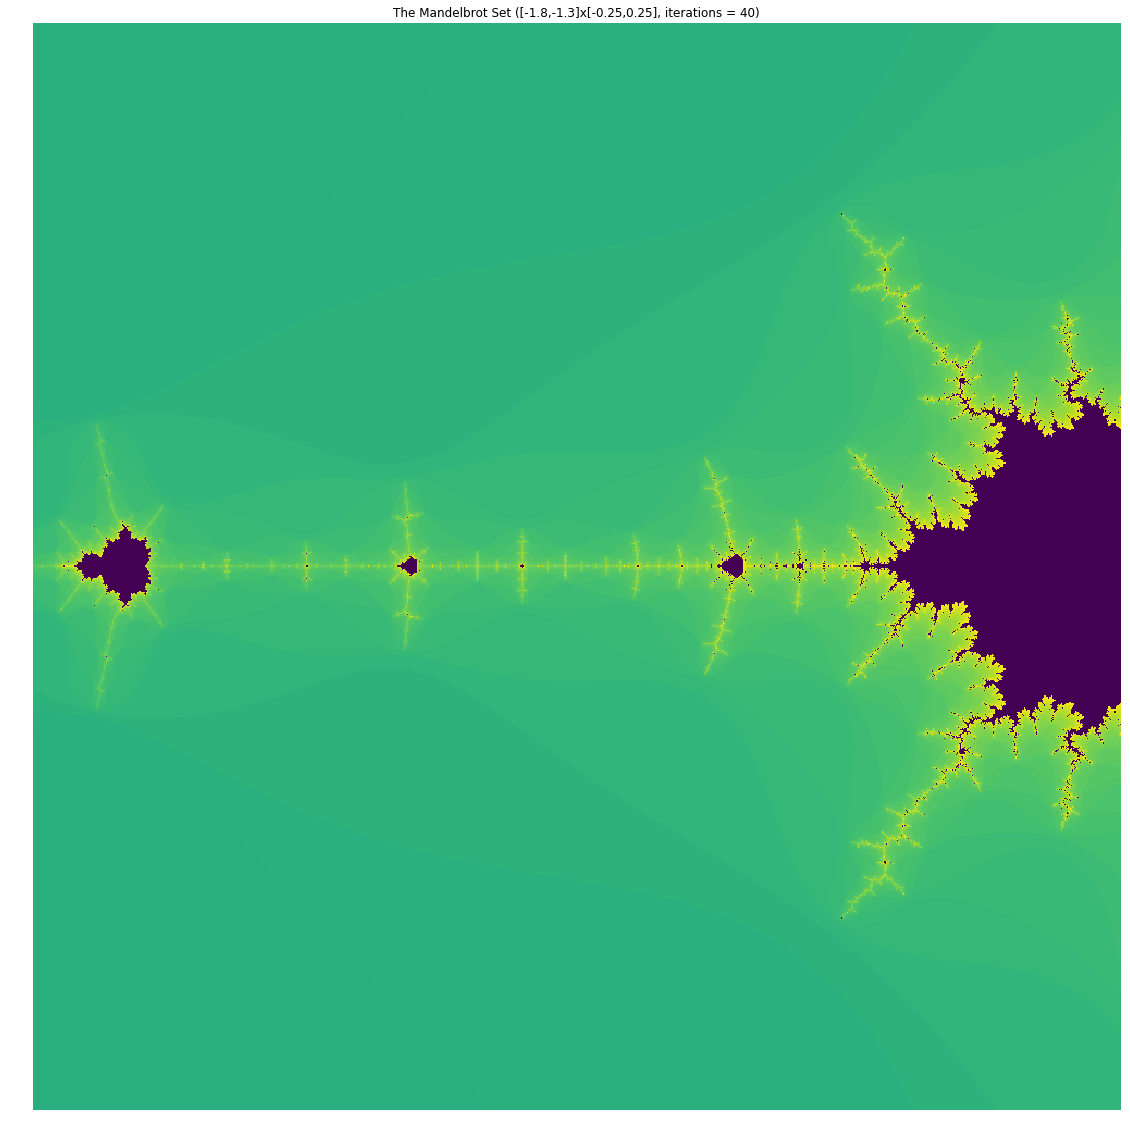

In [27]:
# <!-- collapse=True -->
plt.figure(figsize=(20,20))

plt.imshow(mandelbrot2(1000,1000,-1.8,-1.3,-.25,0.25)) 
s = "The Mandelbrot Set ([-1.8,-1.3]x[-0.25,0.25], iterations = 40)"
plt.title(s)
plt.axis('off')
plt.show()

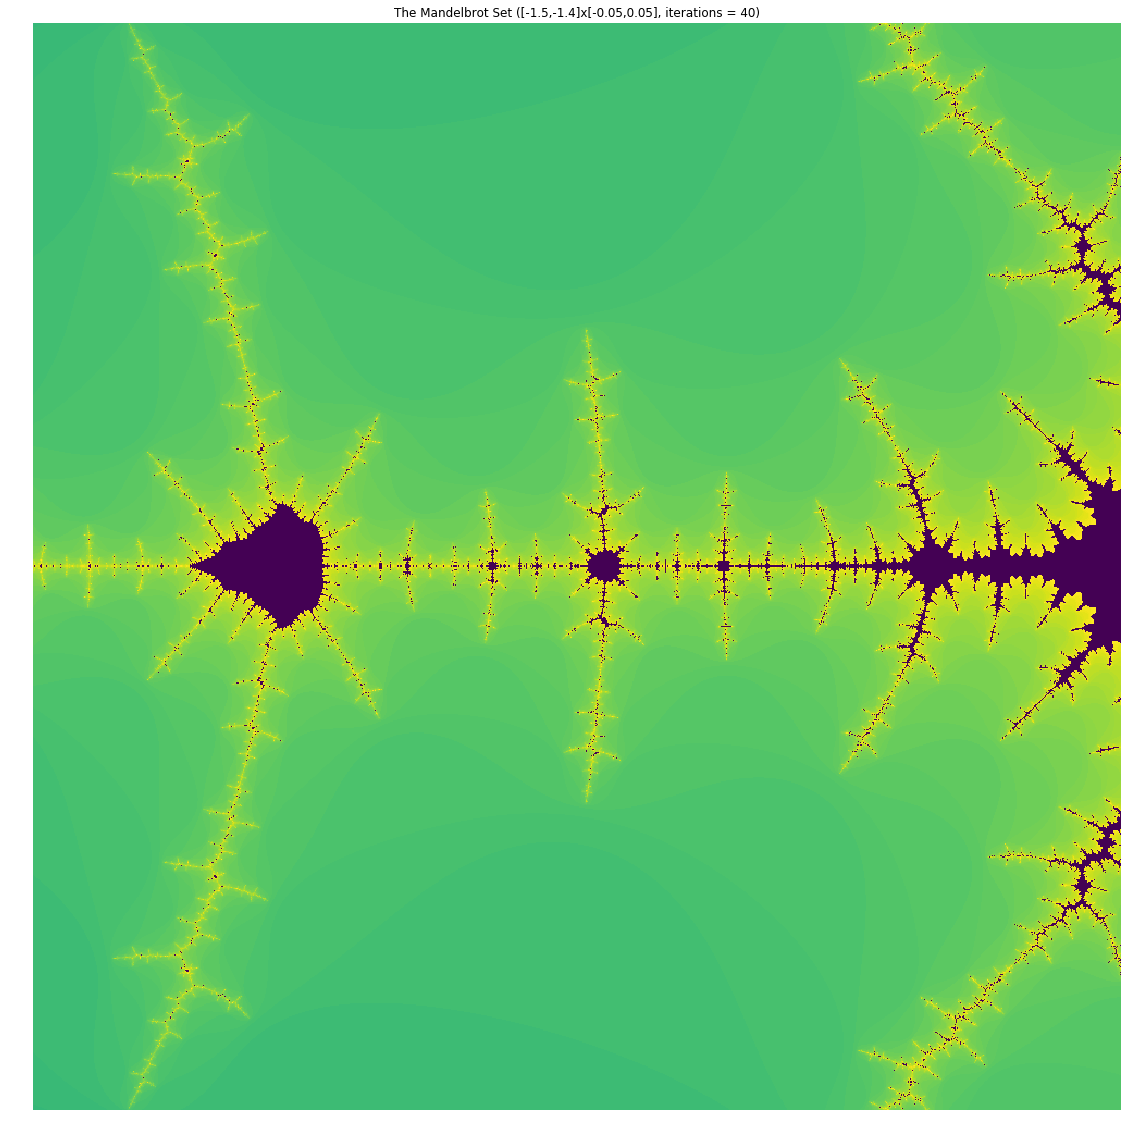

In [28]:
# <!-- collapse=True -->
plt.figure(figsize=(20,20))

plt.imshow(mandelbrot2(1000,1000,-1.5,-1.4,-0.05,0.05)) 
s = "The Mandelbrot Set ([-1.5,-1.4]x[-0.05,0.05], iterations = 40)"
plt.title(s)
plt.axis('off')
plt.show()

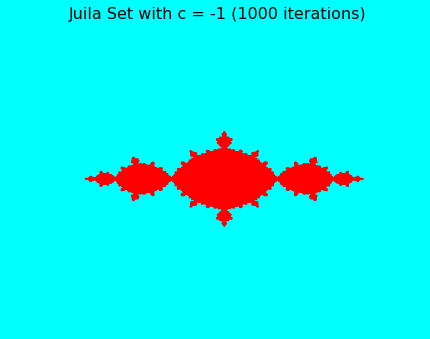

In [23]:
# <!-- collapse=True -->
fig=plt.figure(figsize=(7,5))
fig.patch.set_facecolor('cyan')
ax = plt.subplot(111)#,axisbg='b')
# ax.set_axis_bgcolor('b')
########################################
## c parameter for plot : change this ##
########################################

c = np.complex(-1,0)
#c = np.complex(-0.9,0)
#c = np.complex(0.279,0)

plt.suptitle('Juila Set with c = -1 (1000 iterations)', fontsize=16);
########################################

#########################################################
## Size of side grid for J_c plot: change for accuracy ##
#########################################################
grid = 500;   #500
#########################################################

#############################################################
## number of iterations we use to test for escape : change ##
#############################################################
escape = 1000  #2000
#############################################################

absc = np.abs(c);
rc = 0.5+np.sqrt(0.25+absc);

#####################################
## Region of plot: change for zoom ##
#####################################

xmin = -2.279
xmax = +2.279
ymin = -2.279
ymax = +2.279

# xmin = -2.0
# xmax = +2.0
# ymin = -2.0
# ymax = +2.0

#xmin = 0.0
#xmax = 1.0
#ymin = 0.0
#ymax = 1.0
#xmin = 0.5
#xmax = 0.7
#ymin = 0
#ymax = 0.2
#xmin = 0.6
#xmax = 0.65
#ymin = 0
#ymax = 0.05
#xmin = 0.618
#xmax = 0.619
#ymin = 0
#ymax = 0.001
######################################

x_range = np.arange(xmin, xmax, (xmax - xmin) / grid);
y_range = np.arange(ymin, ymax, (ymax - ymin) / grid);

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
pointSize = (xmax- xmin)/grid;

# Generate keep set points
for y in y_range:
    for x in x_range:
        z = np.complex(x, y)
        escapecount=0

        #  tests if z is in the keep set (i.e. filled in Julia Set)
        while np.abs(z) <= rc and escapecount < escape:
            z = z*z + c;
            escapecount+=1;
            
        # Write point to plot if we have tried to get out escape times and failed
        if escapecount == escape :
            keepSetPoint = plt.Circle((x,y), radius=pointSize, color='r');
            ax.add_patch(keepSetPoint);   

plt.axis("off")    
plt.show()

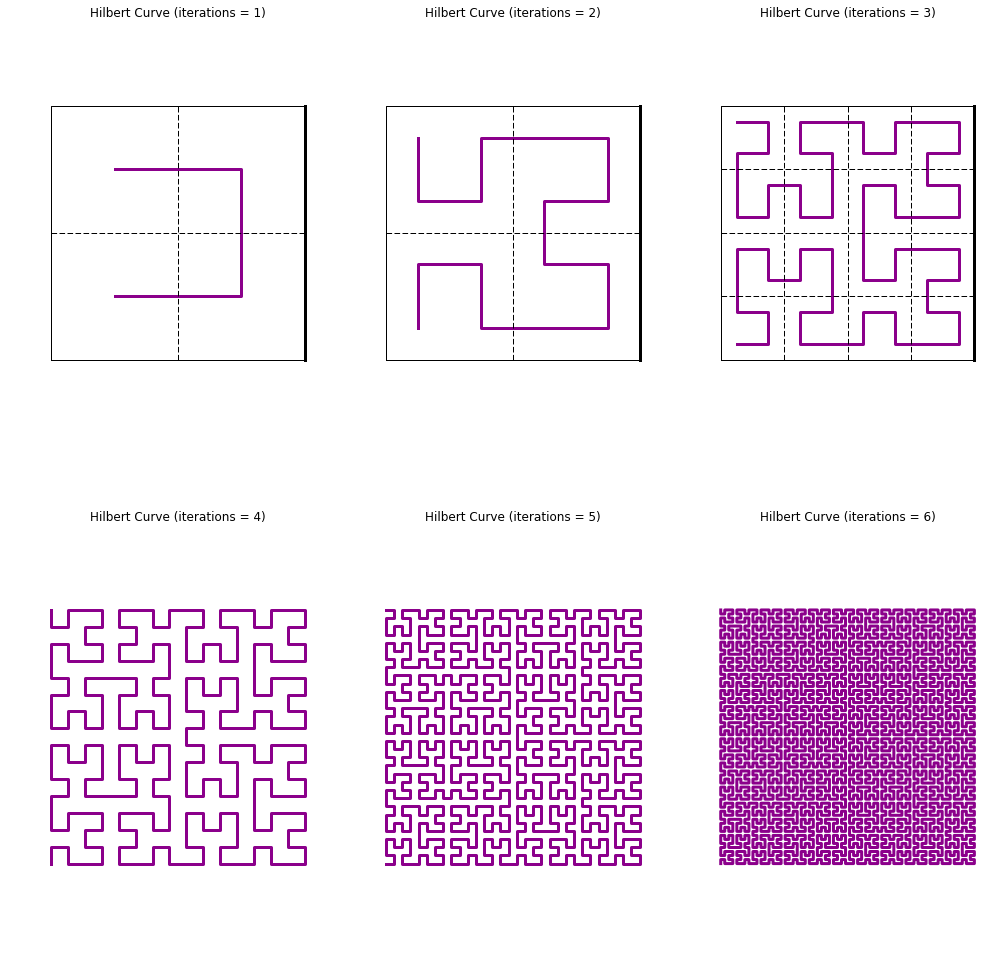

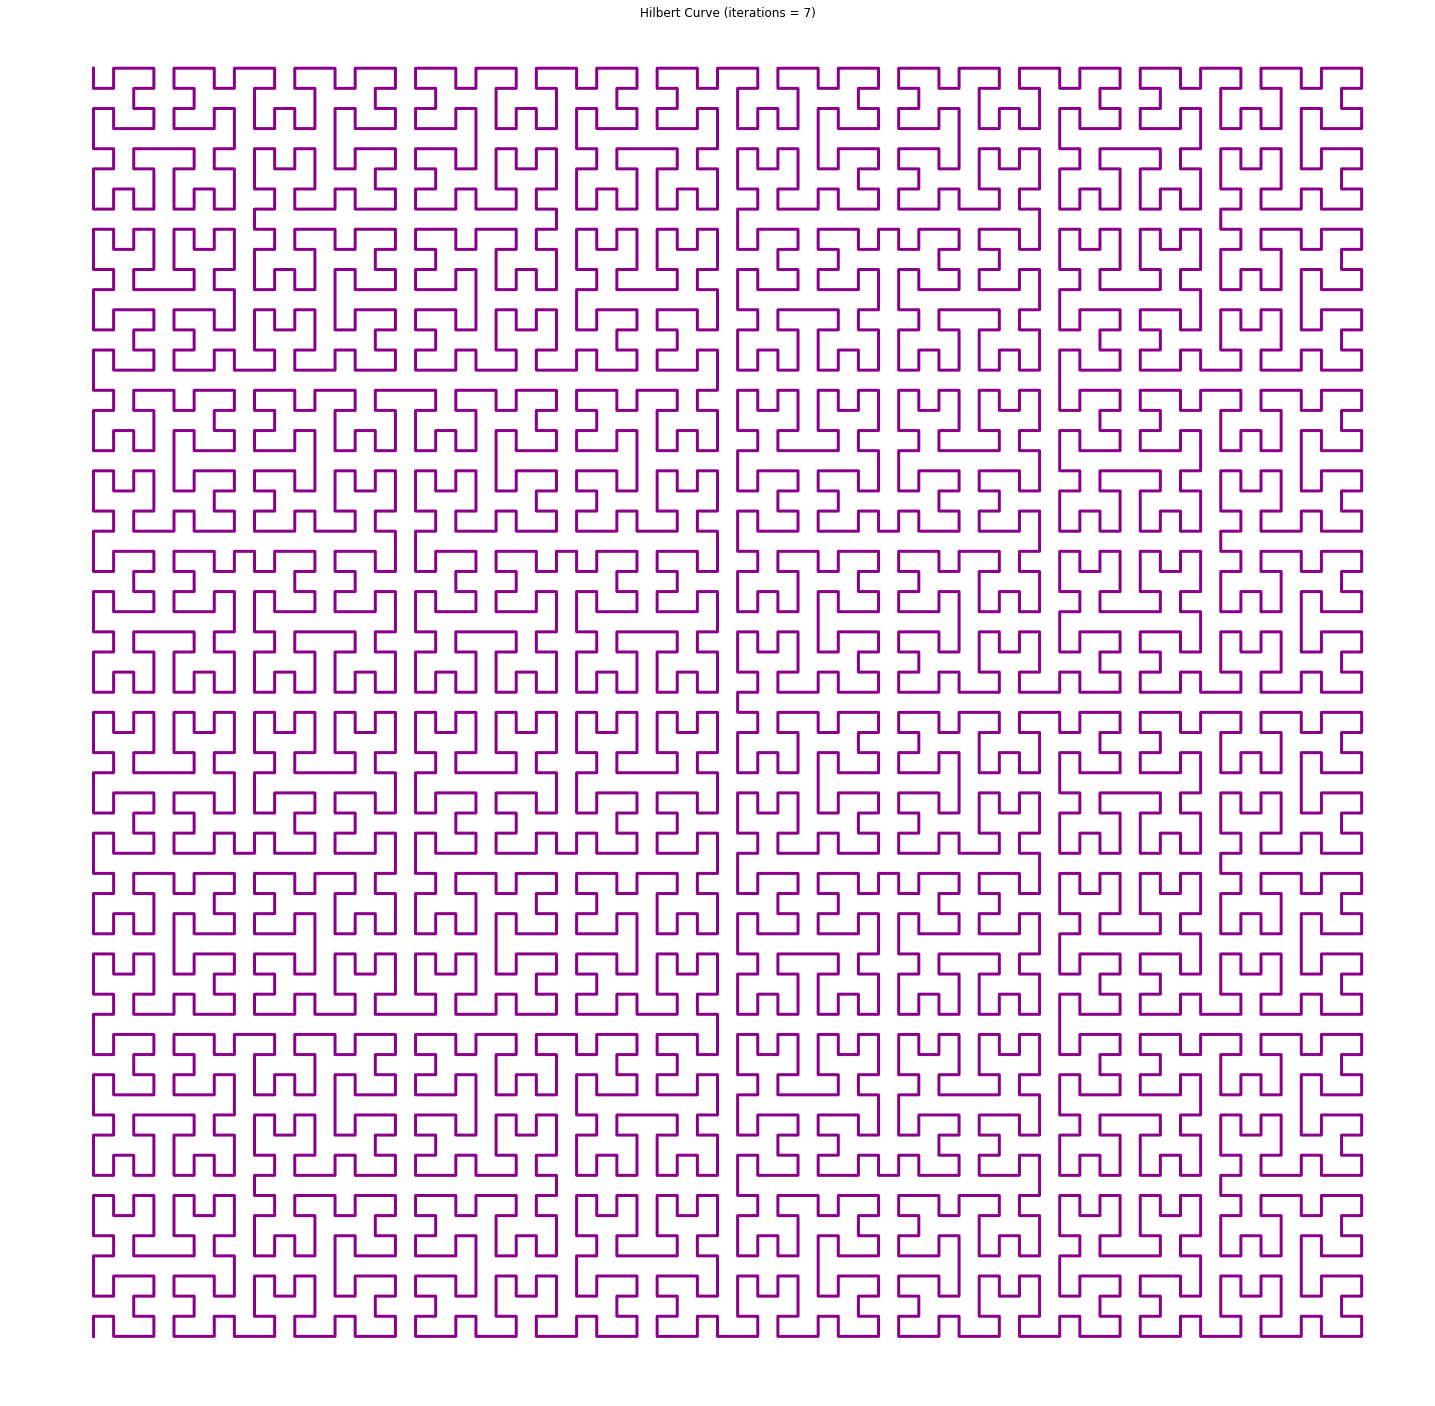

In [24]:
# <!-- collapse=True -->
def hilbert(x0, y0, xi, xj, yi, yj, n,points):
    if n <= 0:
        X = x0 + (xi + yi)/2
        Y = y0 + (xj + yj)/2
        points.append((X,Y))
    else:
        hilbert(x0,               y0,               yi/2, yj/2, xi/2, xj/2, n - 1,points)
        hilbert(x0 + xi/2,        y0 + xj/2,        xi/2, xj/2, yi/2, yj/2, n - 1,points)
        hilbert(x0 + xi/2 + yi/2, y0 + xj/2 + yj/2, xi/2, xj/2, yi/2, yj/2, n - 1,points)
        hilbert(x0 + xi/2 + yi,   y0 + xj/2 + yj,  -yi/2,-yj/2,-xi/2,-xj/2, n - 1,points)
        return points

a = np.array([0, 0])
b = np.array([1, 0])
c = np.array([1, 1])
d = np.array([0, 1])
ab = (a + b)/2.
bc = (b + c)/2.
cd = (c + d)/2.
ad = (d + a)/2.
aab = (a + ab)/2.
bba = (b + ab)/2.
aad = (a + ad)/2.
dda = (d + ad)/2.
ccb = (c + bc)/2.
bbc = (b + bc)/2.
ccd = (c + cd)/2.
ddc = (d + cd)/2.

iterations = 1

fig = plt.figure(figsize=(17,17))
plt.subplot(2,3,1).set_title("Hilbert Curve (iterations = 1)")

points = hilbert(0.0, 0.0, 1.0, 0.0, 0.0, 1.0, iterations,[])
plt.plot([p[0] for p in points], [p[1] for p in points], '-',lw=3,color='darkmagenta')

plt.plot([a[0],b[0],c[0],d[0],a[0]],[a[1],b[1],c[1],d[1],a[1]],'k-',lw=1)
plt.plot([ab[0],cd[0]],[ab[1],cd[1]],'k--',lw=1)
plt.plot([ad[0],bc[0]],[ad[1],bc[1]],'k--',lw=1)
plt.plot([b[0],c[0]],[b[1],c[1]],'k-',lw=3)

plt.axis('equal')
plt.axis('off')

iterations = 2

plt.subplot(2,3,2).set_title("Hilbert Curve (iterations = 2)")

points = hilbert(0.0, 0.0, 1.0, 0.0, 0.0, 1.0, iterations,[])
plt.plot([p[0] for p in points], [p[1] for p in points], '-',lw=3,color='darkmagenta')#,lw=5)

plt.plot([a[0],b[0],c[0],d[0],a[0]],[a[1],b[1],c[1],d[1],a[1]],'k-',lw=1)
plt.plot([ab[0],cd[0]],[ab[1],cd[1]],'k--',lw=1)
plt.plot([ad[0],bc[0]],[ad[1],bc[1]],'k--',lw=1)
plt.plot([b[0],c[0]],[b[1],c[1]],'k-',lw=3)

plt.axis('equal')
plt.axis('off')

iterations = 3

plt.subplot(2,3,3).set_title("Hilbert Curve (iterations = 3)")

points = hilbert(0.0, 0.0, 1.0, 0.0, 0.0, 1.0, iterations,[])
plt.plot([p[0] for p in points], [p[1] for p in points], '-',lw=3,color='darkmagenta')#,lw=5)

plt.plot([a[0],b[0],c[0],d[0],a[0]],[a[1],b[1],c[1],d[1],a[1]],'k-',lw=1)
plt.plot([ab[0],cd[0]],[ab[1],cd[1]],'k--',lw=1)
plt.plot([ad[0],bc[0]],[ad[1],bc[1]],'k--',lw=1)
plt.plot([b[0],c[0]],[b[1],c[1]],'k-',lw=3)
plt.plot([aab[0],ddc[0]],[aab[1],ddc[1]],'k--',lw=1)
plt.plot([bba[0],ccd[0]],[bba[1],ccd[1]],'k--',lw=1)
plt.plot([aad[0],bbc[0]],[aad[1],bbc[1]],'k--',lw=1)
plt.plot([dda[0],ccb[0]],[dda[1],ccb[1]],'k--',lw=1)

plt.axis('equal')
plt.axis('off')

iterations = 4

plt.subplot(2,3,4).set_title("Hilbert Curve (iterations = 4)")

points = hilbert(0.0, 0.0, 1.0, 0.0, 0.0, 1.0, iterations,[])
plt.plot([p[0] for p in points], [p[1] for p in points], '-',lw=3,color='darkmagenta')#,lw=5)

plt.axis('equal')
plt.axis('off')

iterations = 5

plt.subplot(2,3,5).set_title("Hilbert Curve (iterations = 5)")

points = hilbert(0.0, 0.0, 1.0, 0.0, 0.0, 1.0, iterations,[])
plt.plot([p[0] for p in points], [p[1] for p in points], '-',lw=3,color='darkmagenta')#,lw=5)

plt.axis('equal')
plt.axis('off')
iterations = 6

plt.subplot(2,3,6).set_title("Hilbert Curve (iterations = 6)")

points = hilbert(0.0, 0.0, 1.0, 0.0, 0.0, 1.0, iterations,[])
plt.plot([p[0] for p in points], [p[1] for p in points], '-',lw=3,color='darkmagenta')#,lw=5)

plt.axis('equal')
plt.axis('off')

fig = plt.figure(figsize=(25,25))

points = hilbert(0.0, 0.0, 1.0, 0.0, 0.0, 1.0, iterations,[])
plt.plot([p[0] for p in points], [p[1] for p in points], '-',lw=3,color='darkmagenta')#,lw=5)
plt.title("Hilbert Curve (iterations = 7)")
plt.axis('equal')
plt.axis('off')

plt.show()

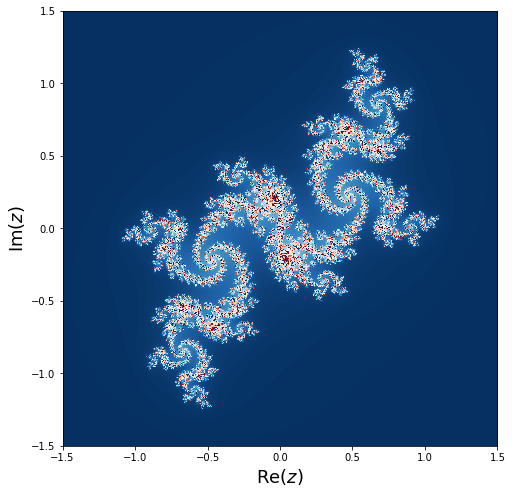

In [31]:
# <!-- collapse=True -->
# Graficando el fractal de Julia
def py_julia_fractal(z_re, z_im, j):
    '''Crea el grafico del fractal de Julia.'''
    for m in range(len(z_re)):
        for n in range(len(z_im)):
            z = z_re[m] + 1j * z_im[n]
            for t in range(256):
                z = z ** 2 - 0.05 + 0.68j
                if np.abs(z) > 2.0:
                    j[m, n] = t
                    break
                    
jit_julia_fractal = numba.jit(nopython=True)(py_julia_fractal)

N = 1024
j = np.zeros((N, N), np.int64)
z_real = np.linspace(-1.5, 1.5, N)
z_imag = np.linspace(-1.5, 1.5, N)
jit_julia_fractal(z_real, z_imag, j)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(j, cmap=plt.cm.RdBu_r, extent=[-1.5, 1.5, -1.5, 1.5])
ax.set_xlabel("$\mathrm{Re}(z)$", fontsize=18)
ax.set_ylabel("$\mathrm{Im}(z)$", fontsize=18)
plt.show()

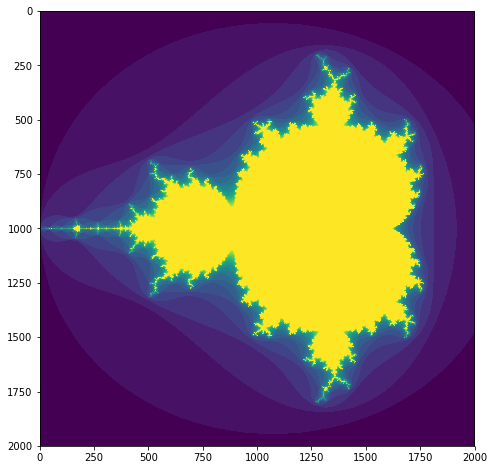

In [32]:
# <!-- collapse=True -->
# Graficando el conjunto de Mandelbrot 
def mandelbrot( h,w, maxit=20 ):
    '''Crea el grafico del fractal de Mandelbrot del tamaño (h,w).'''
    y,x = np.ogrid[ -1.4:1.4:h*1j, -2:0.8:w*1j ]
    c = x+y*1j
    z = c
    divtime = maxit + np.zeros(z.shape, dtype=int)
    
    for i in range(maxit):
        z  = z**2 + c
        diverge = z*np.conj(z) > 2**2         
        div_now = diverge & (divtime==maxit)  
        divtime[div_now] = i                  
        z[diverge] = 2                        
        
    return divtime

plt.figure(figsize=(8,8))
plt.imshow(mandelbrot(2000,2000))
plt.show()

In [1]:
from fractal import Fern, Sierpinski, Vicsek, Tree, Dragon, Koch, Hilbert, Levy

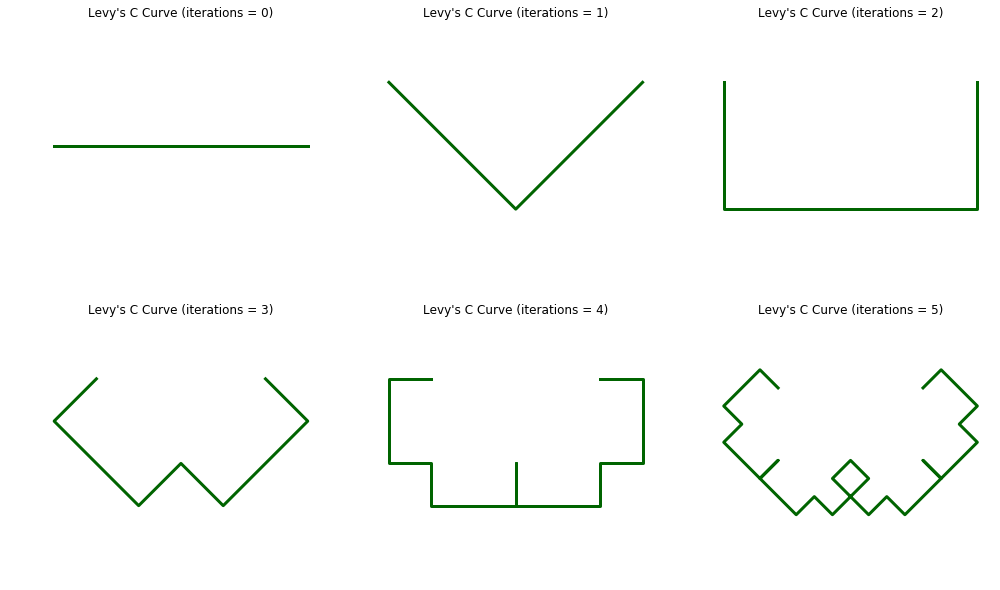

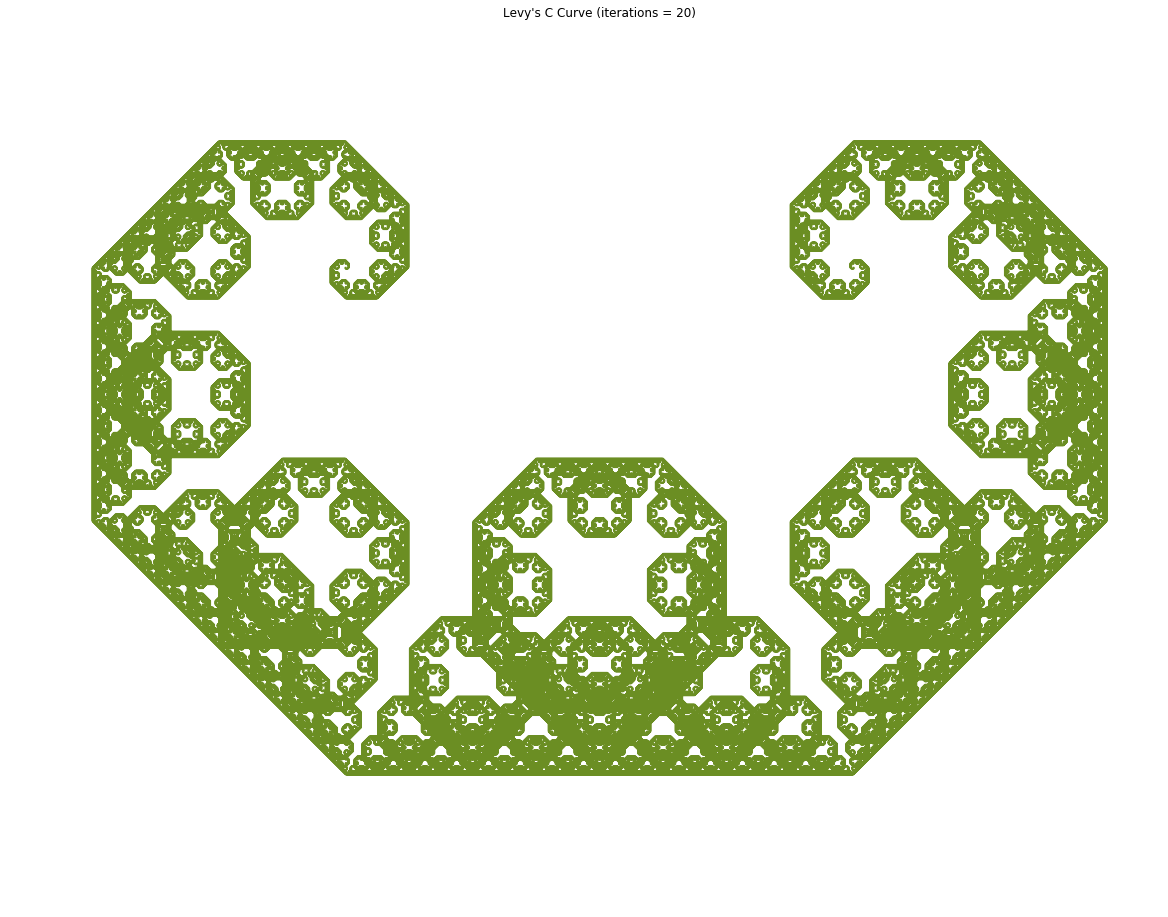

In [2]:
levy = Levy()
levy.plot()

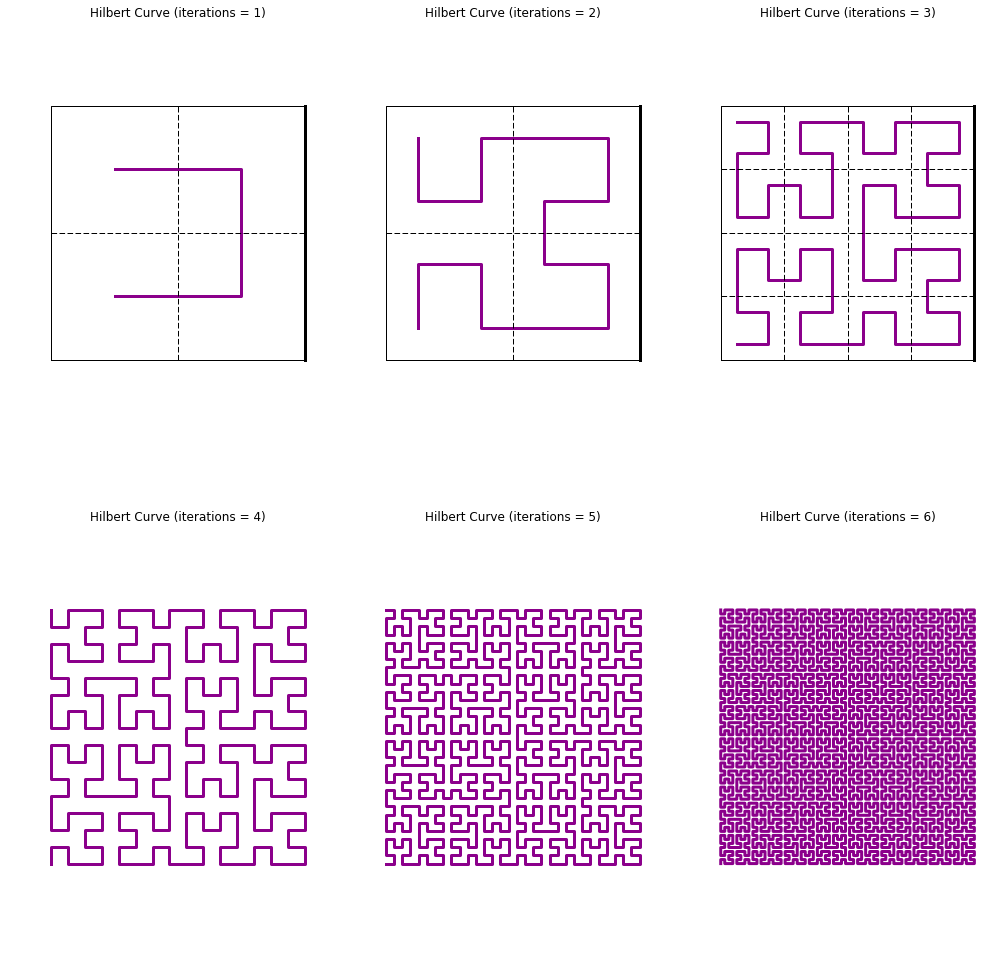

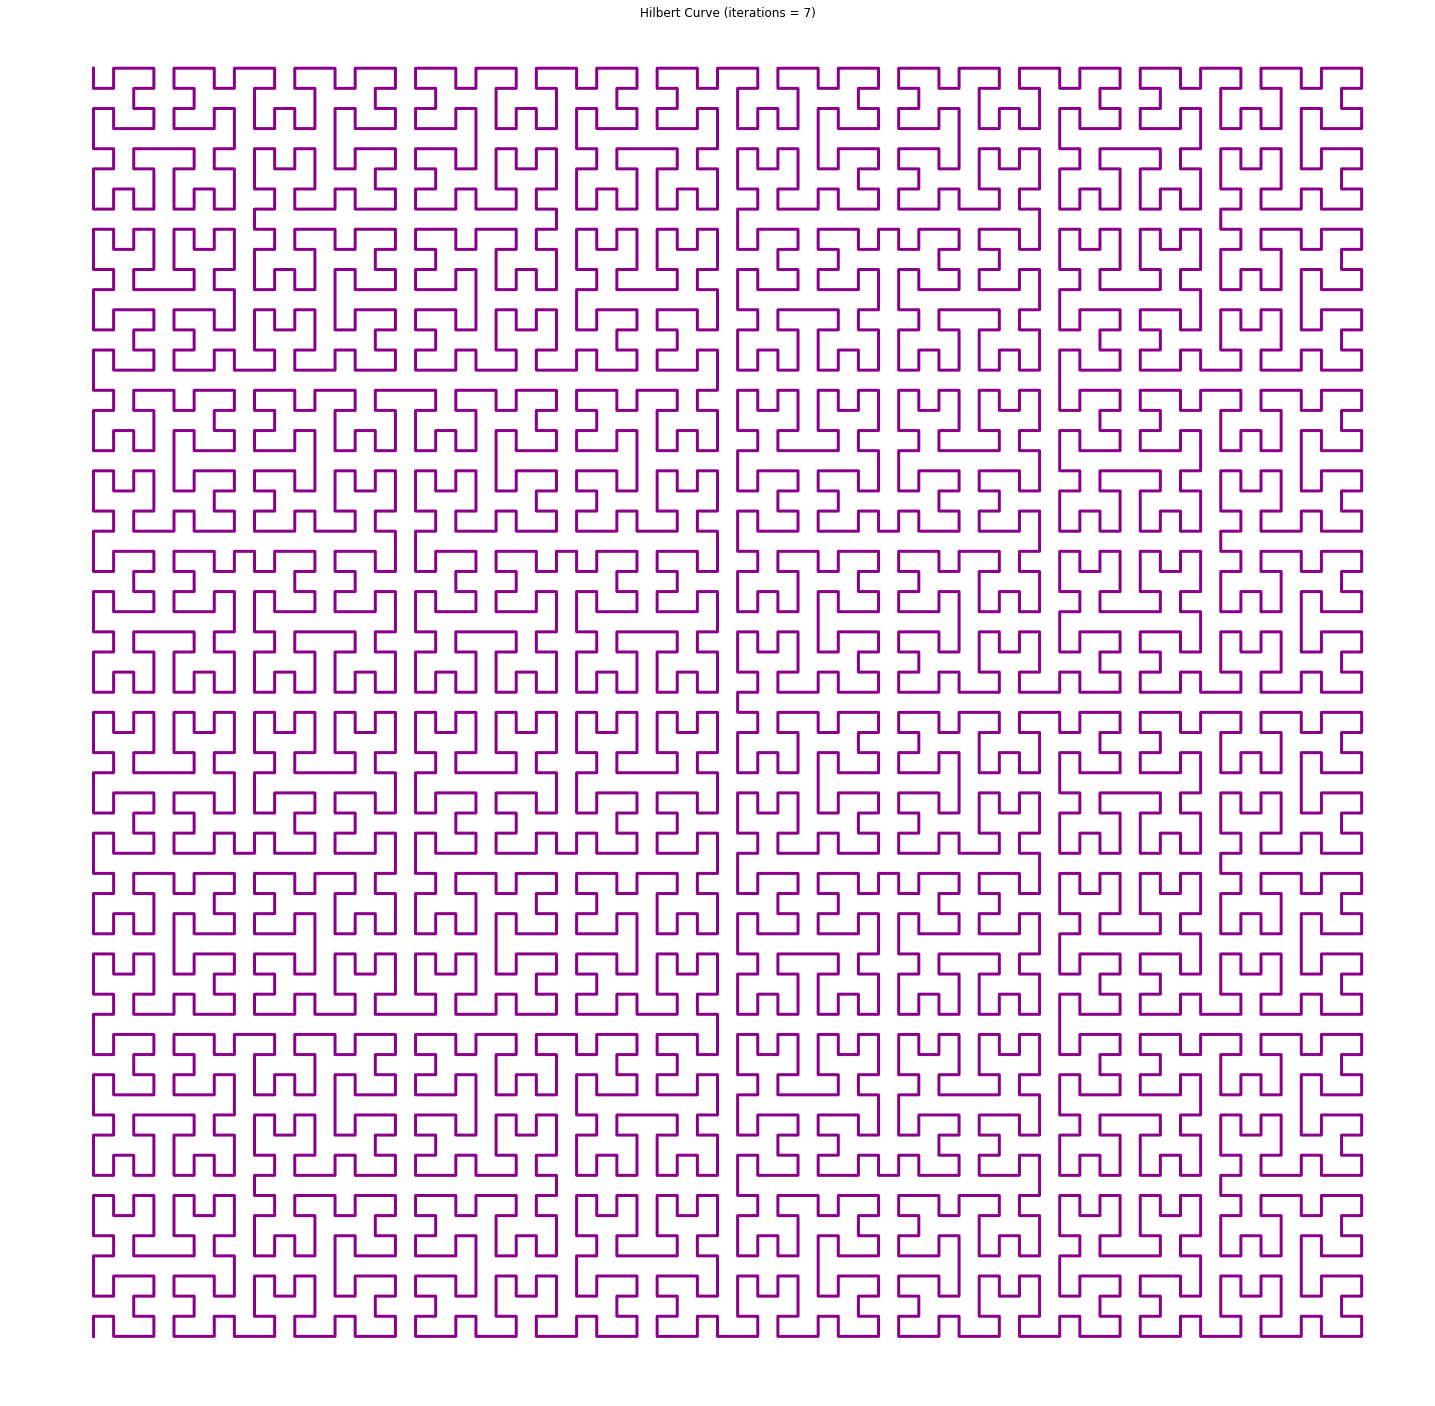

In [2]:
hilbert = Hilbert()
hilbert.plot()

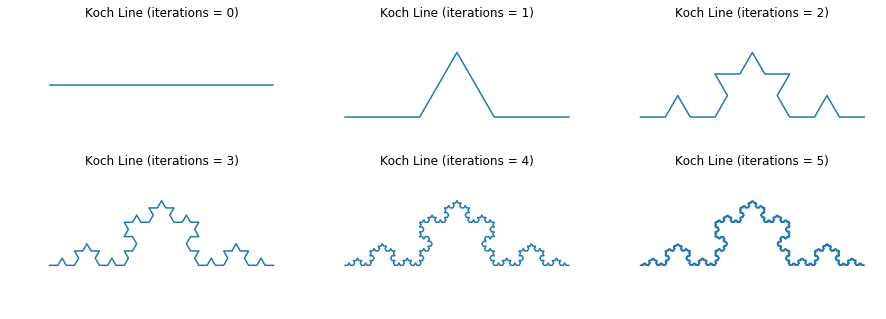

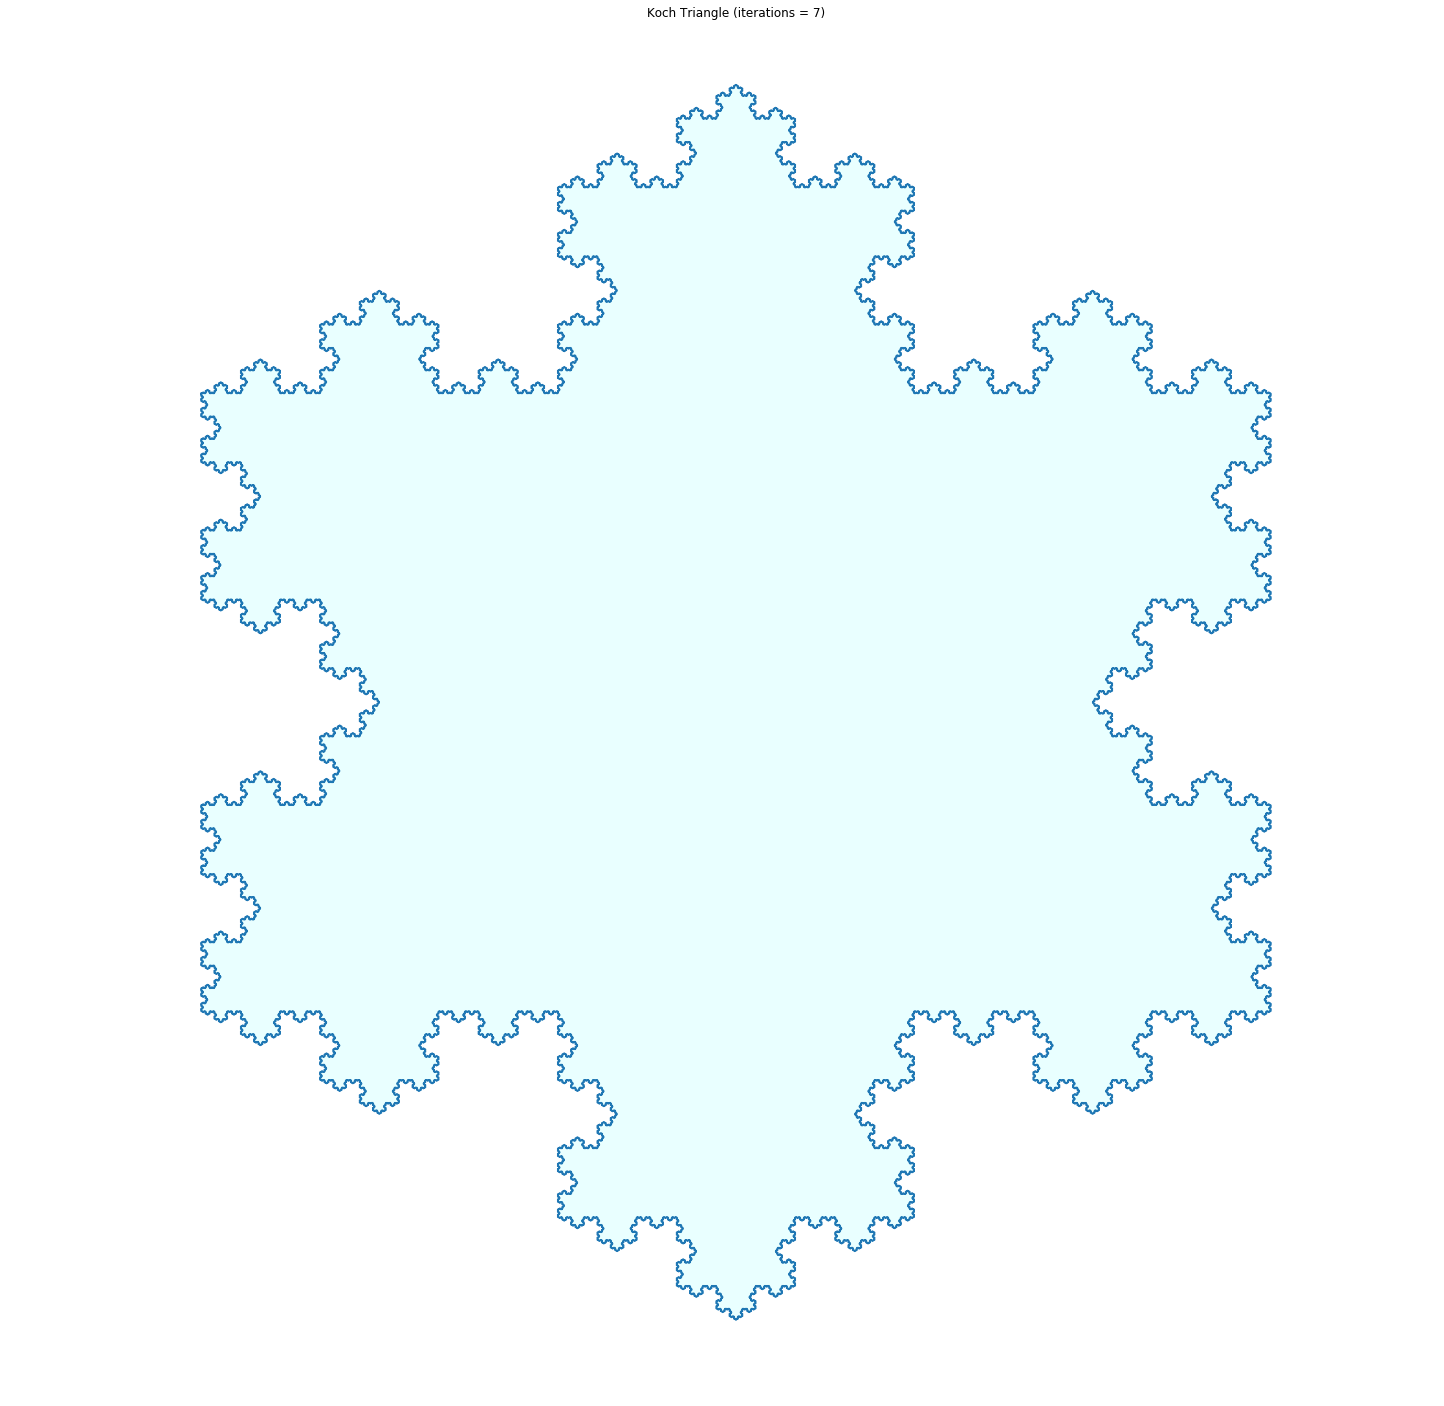

In [2]:
koch = Koch()
koch.plot()

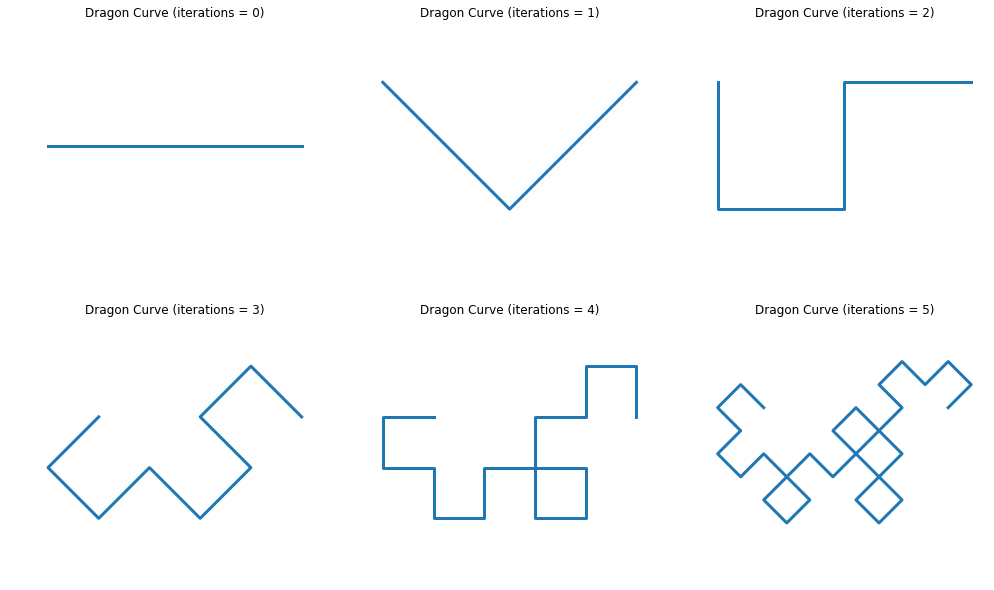

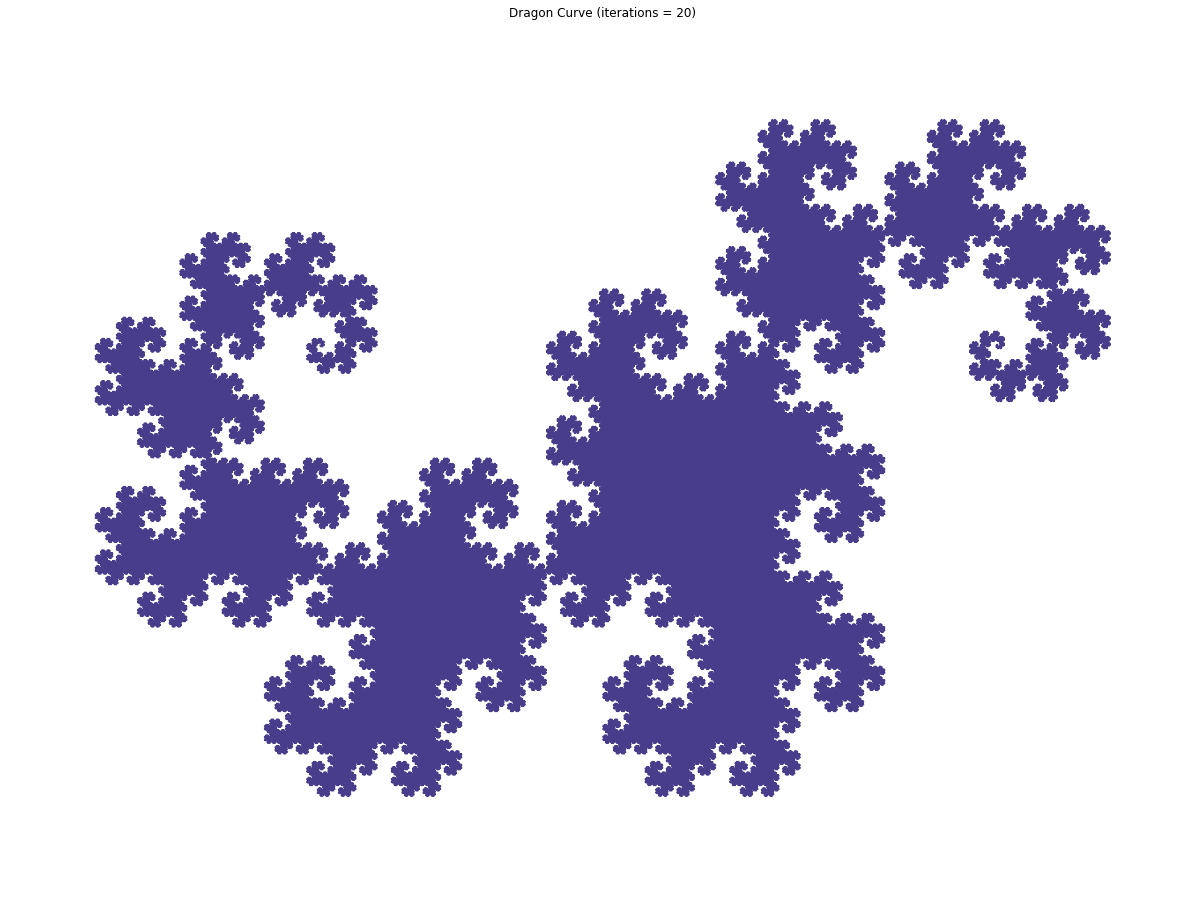

In [2]:
dragon = Dragon()
dragon.plot()

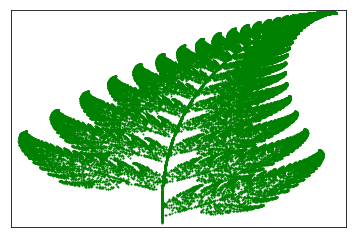

In [2]:
fern = Fern()
fern.plot()

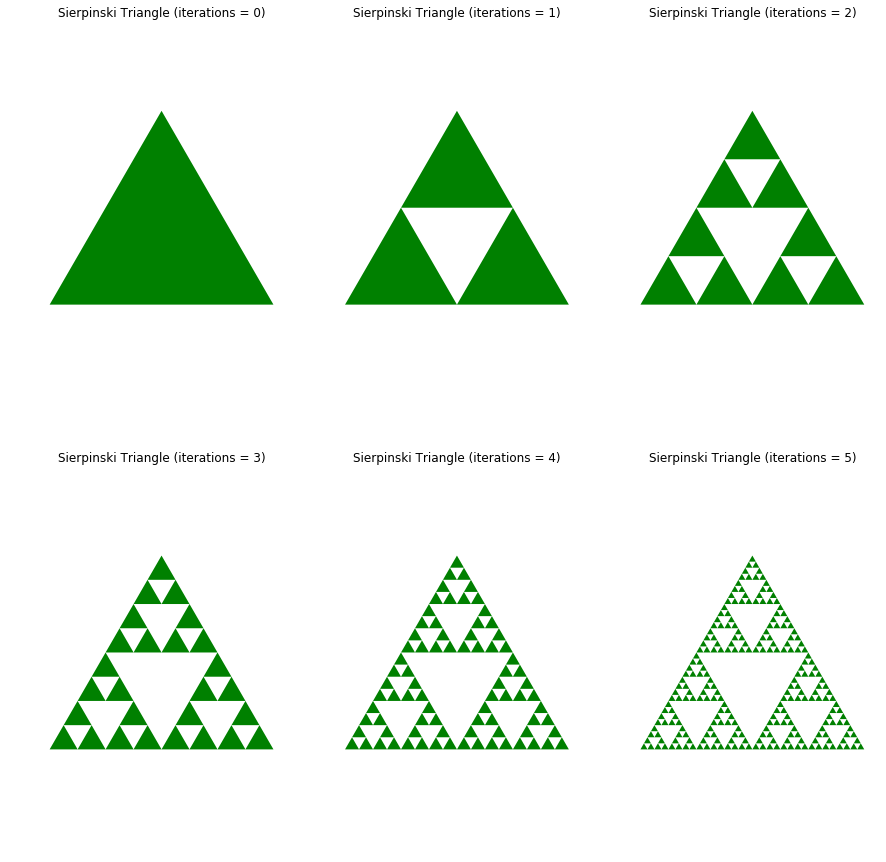

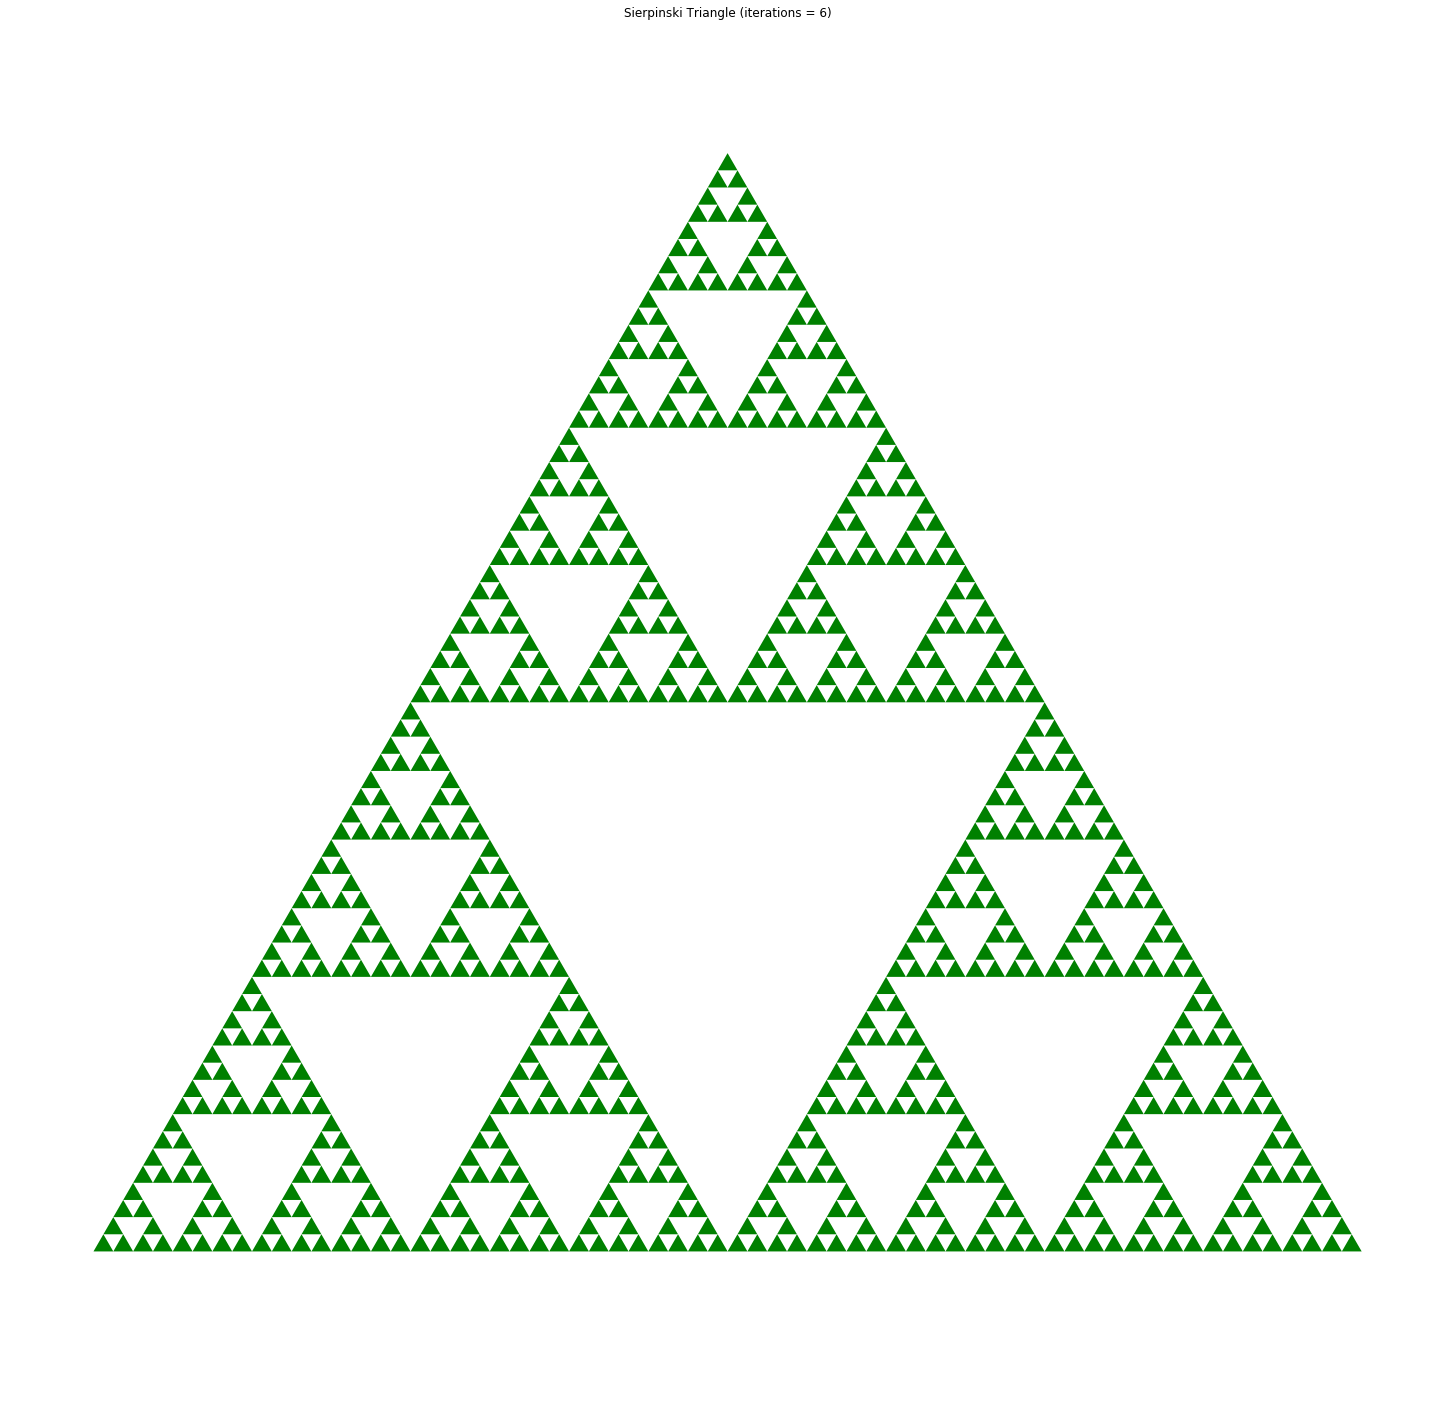

In [3]:
sierpinski = Sierpinski()
sierpinski.plot()

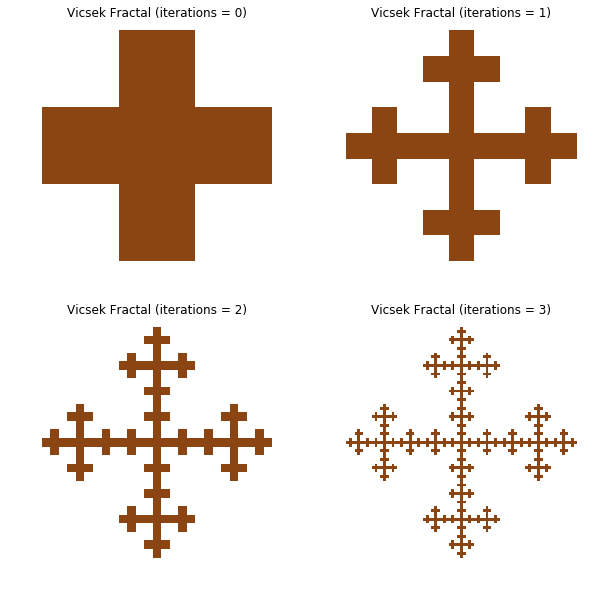

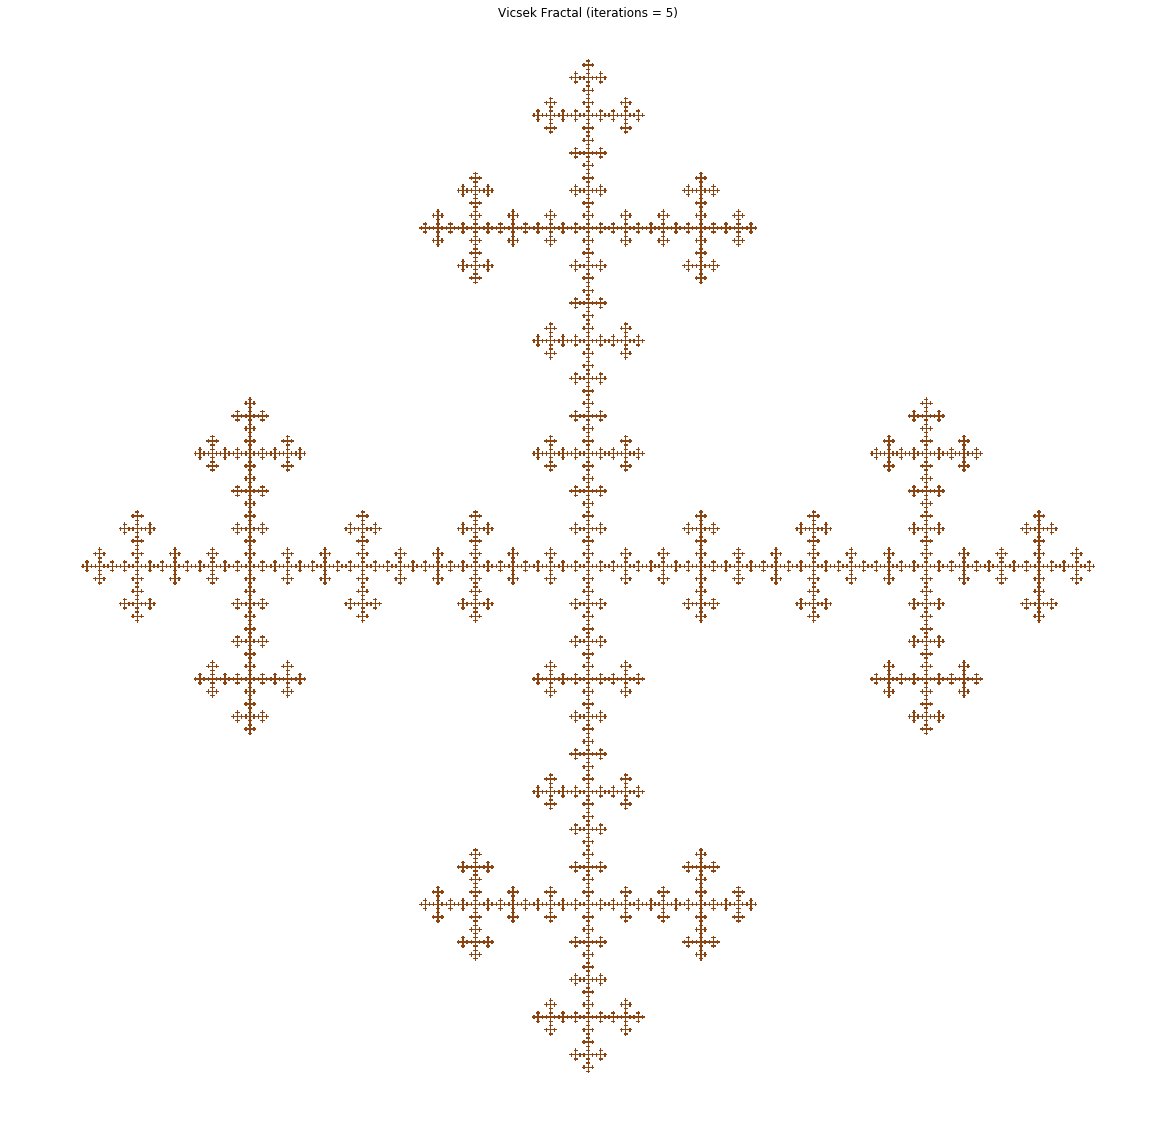

In [2]:
vicsek = Vicsek()
vicsek.plot()

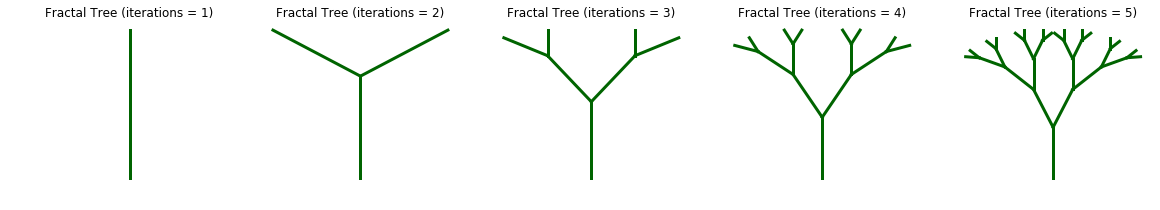

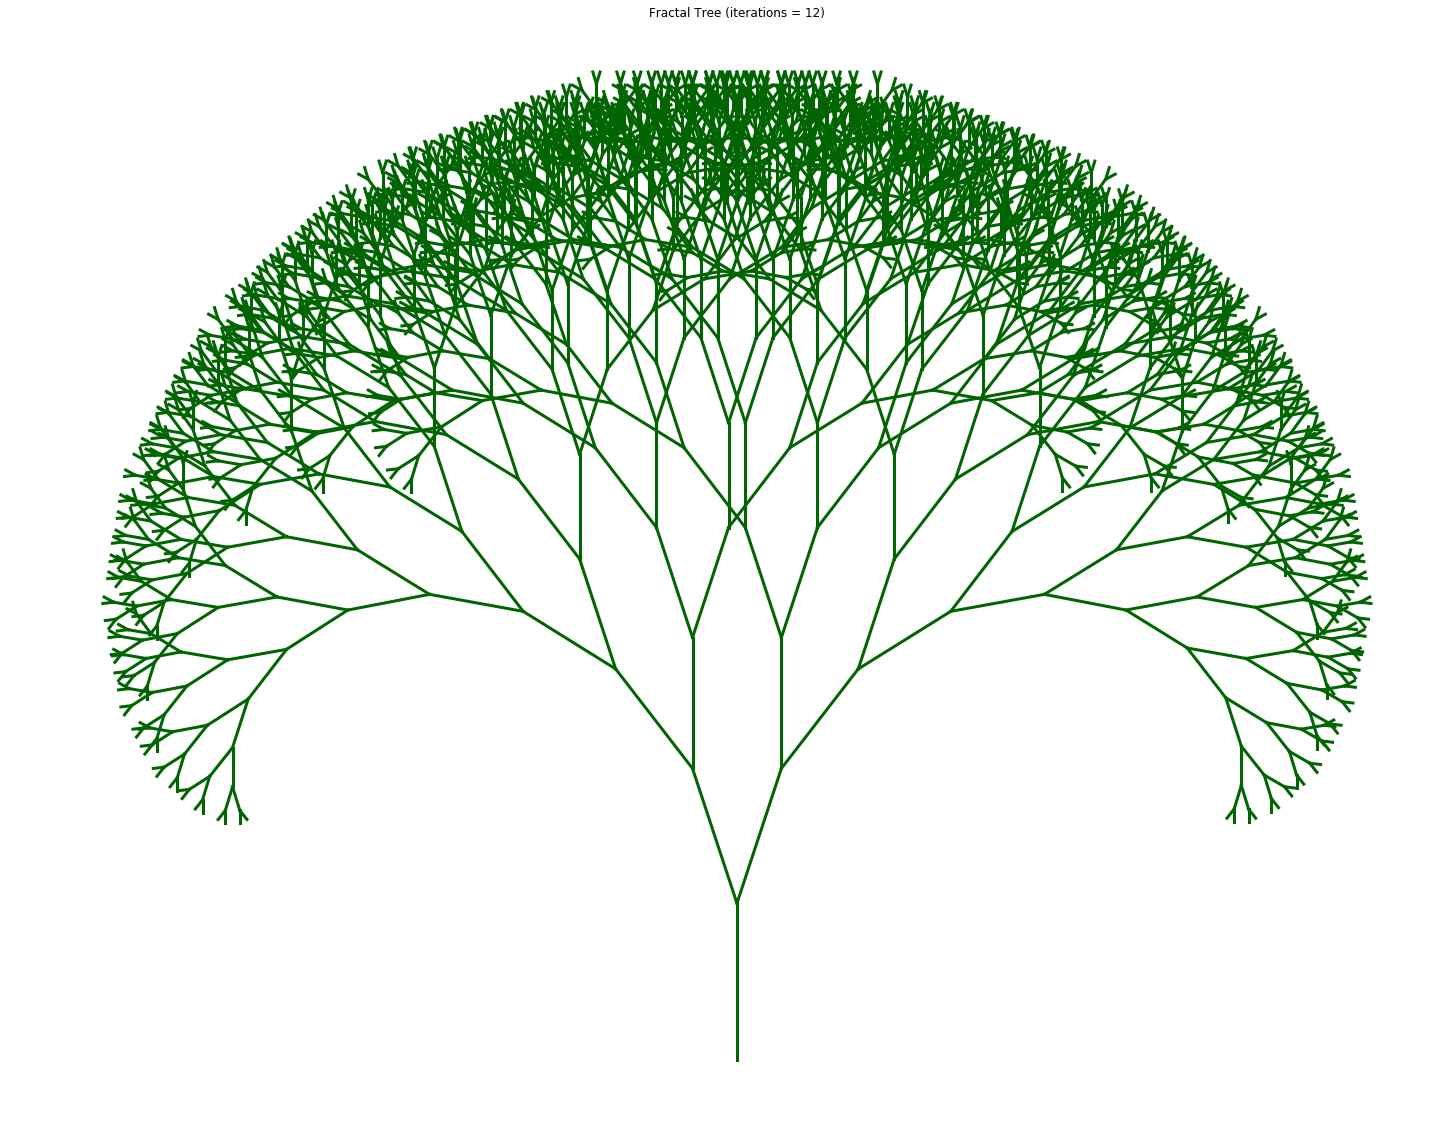

In [2]:
tree = Tree()
tree.plot()